# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

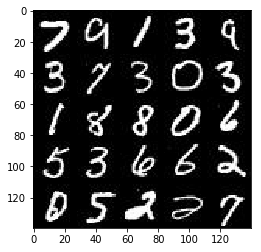

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

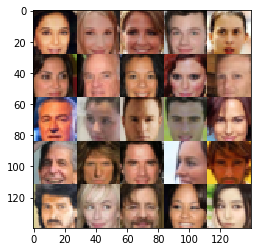

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x512

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = 0.2
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    steps = 0
    show_stats_every = 10
    show_image_every = 100
    nb_images = 16
    is_train = tf.placeholder(tf.bool)
    
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height,image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                #let's rescale !
                batch_images = batch_images * 2
                
                # Sample random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                # I Run the generator optimizer 2 times to slow down convergence of the discriminator network
                # This makes a huge difference on training speed for my generator !
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate })
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate,is_train:True})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate,is_train:True})
                
                if steps % show_stats_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_image_every == 0:
                    #Print the current image
                    show_generator_output(sess, nb_images, input_z, image_channels, data_image_mode)
            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/5... Discriminator Loss: 0.0002... Generator Loss: 23.7887
Epoch 1/5... Discriminator Loss: 3.4474... Generator Loss: 7.4266
Epoch 1/5... Discriminator Loss: 2.0491... Generator Loss: 3.9562
Epoch 1/5... Discriminator Loss: 2.8093... Generator Loss: 0.2687
Epoch 1/5... Discriminator Loss: 1.4960... Generator Loss: 0.6245
Epoch 1/5... Discriminator Loss: 1.6977... Generator Loss: 0.3642
Epoch 1/5... Discriminator Loss: 1.4745... Generator Loss: 0.5324
Epoch 1/5... Discriminator Loss: 1.3763... Generator Loss: 0.6155
Epoch 1/5... Discriminator Loss: 1.8762... Generator Loss: 1.4148
Epoch 1/5... Discriminator Loss: 1.6197... Generator Loss: 0.3484


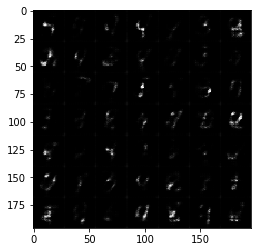

Epoch 1/5... Discriminator Loss: 1.4716... Generator Loss: 0.6939
Epoch 1/5... Discriminator Loss: 2.0011... Generator Loss: 0.4788
Epoch 1/5... Discriminator Loss: 1.6027... Generator Loss: 0.3908
Epoch 1/5... Discriminator Loss: 1.5102... Generator Loss: 0.7840
Epoch 1/5... Discriminator Loss: 1.4032... Generator Loss: 0.8141
Epoch 1/5... Discriminator Loss: 1.5516... Generator Loss: 0.4901
Epoch 1/5... Discriminator Loss: 1.7573... Generator Loss: 0.3100
Epoch 1/5... Discriminator Loss: 1.8863... Generator Loss: 0.7012
Epoch 1/5... Discriminator Loss: 1.7325... Generator Loss: 0.3083
Epoch 1/5... Discriminator Loss: 1.6551... Generator Loss: 0.3423


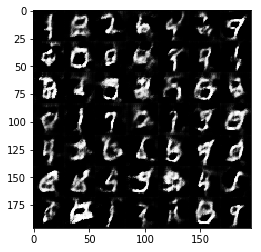

Epoch 1/5... Discriminator Loss: 1.6948... Generator Loss: 0.8584
Epoch 1/5... Discriminator Loss: 1.6710... Generator Loss: 0.5499
Epoch 1/5... Discriminator Loss: 1.6989... Generator Loss: 0.5675
Epoch 1/5... Discriminator Loss: 1.6870... Generator Loss: 0.3918
Epoch 1/5... Discriminator Loss: 1.7282... Generator Loss: 0.3616
Epoch 1/5... Discriminator Loss: 1.5178... Generator Loss: 1.0505
Epoch 1/5... Discriminator Loss: 1.5426... Generator Loss: 0.5310
Epoch 1/5... Discriminator Loss: 1.5802... Generator Loss: 0.4154
Epoch 1/5... Discriminator Loss: 1.4287... Generator Loss: 0.5013
Epoch 1/5... Discriminator Loss: 1.6875... Generator Loss: 0.3304


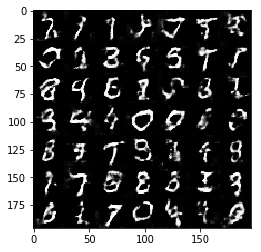

Epoch 1/5... Discriminator Loss: 1.7213... Generator Loss: 0.8804
Epoch 1/5... Discriminator Loss: 1.5018... Generator Loss: 0.6838
Epoch 1/5... Discriminator Loss: 1.4696... Generator Loss: 0.6872
Epoch 1/5... Discriminator Loss: 1.6738... Generator Loss: 0.3654
Epoch 1/5... Discriminator Loss: 1.5198... Generator Loss: 0.4226
Epoch 1/5... Discriminator Loss: 1.3994... Generator Loss: 0.6480
Epoch 1/5... Discriminator Loss: 1.5263... Generator Loss: 0.6301
Epoch 1/5... Discriminator Loss: 1.5368... Generator Loss: 1.0124
Epoch 1/5... Discriminator Loss: 1.5397... Generator Loss: 0.8086
Epoch 1/5... Discriminator Loss: 1.6902... Generator Loss: 0.3255


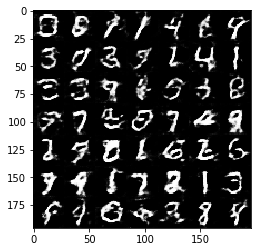

Epoch 1/5... Discriminator Loss: 1.5118... Generator Loss: 0.4731
Epoch 1/5... Discriminator Loss: 1.5536... Generator Loss: 0.5574
Epoch 1/5... Discriminator Loss: 1.6935... Generator Loss: 1.4954
Epoch 1/5... Discriminator Loss: 1.6031... Generator Loss: 0.4251
Epoch 1/5... Discriminator Loss: 1.5195... Generator Loss: 0.7210
Epoch 1/5... Discriminator Loss: 1.5878... Generator Loss: 0.5305
Epoch 1/5... Discriminator Loss: 1.6683... Generator Loss: 0.3233
Epoch 1/5... Discriminator Loss: 1.5069... Generator Loss: 0.3663
Epoch 1/5... Discriminator Loss: 1.4710... Generator Loss: 0.4706
Epoch 1/5... Discriminator Loss: 1.4750... Generator Loss: 0.6464


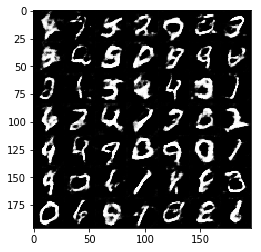

Epoch 1/5... Discriminator Loss: 1.5445... Generator Loss: 0.8878
Epoch 1/5... Discriminator Loss: 1.4023... Generator Loss: 0.5903
Epoch 1/5... Discriminator Loss: 1.3980... Generator Loss: 0.7884
Epoch 1/5... Discriminator Loss: 3.0188... Generator Loss: 2.3339
Epoch 1/5... Discriminator Loss: 1.3706... Generator Loss: 0.6187
Epoch 1/5... Discriminator Loss: 1.4715... Generator Loss: 0.7847
Epoch 1/5... Discriminator Loss: 1.3024... Generator Loss: 0.7810
Epoch 1/5... Discriminator Loss: 1.3542... Generator Loss: 0.5045
Epoch 1/5... Discriminator Loss: 1.9159... Generator Loss: 0.1998
Epoch 1/5... Discriminator Loss: 1.9006... Generator Loss: 1.2909


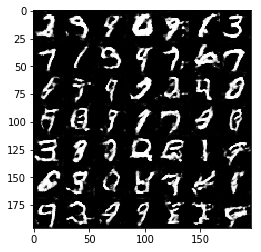

Epoch 1/5... Discriminator Loss: 1.7502... Generator Loss: 0.2646
Epoch 1/5... Discriminator Loss: 2.1382... Generator Loss: 1.4226
Epoch 1/5... Discriminator Loss: 1.5009... Generator Loss: 0.5898
Epoch 1/5... Discriminator Loss: 1.5494... Generator Loss: 0.4547
Epoch 1/5... Discriminator Loss: 1.7080... Generator Loss: 0.2942
Epoch 1/5... Discriminator Loss: 1.4870... Generator Loss: 0.8878
Epoch 1/5... Discriminator Loss: 1.5613... Generator Loss: 0.3215
Epoch 1/5... Discriminator Loss: 1.5344... Generator Loss: 0.7094
Epoch 1/5... Discriminator Loss: 1.5890... Generator Loss: 0.3156
Epoch 1/5... Discriminator Loss: 1.5431... Generator Loss: 0.3768


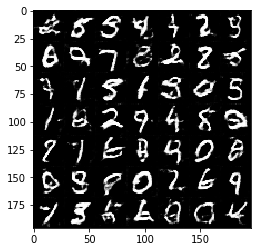

Epoch 1/5... Discriminator Loss: 1.4021... Generator Loss: 0.4518
Epoch 1/5... Discriminator Loss: 1.4548... Generator Loss: 0.6929
Epoch 1/5... Discriminator Loss: 1.3978... Generator Loss: 0.6944
Epoch 1/5... Discriminator Loss: 1.4086... Generator Loss: 0.8684
Epoch 1/5... Discriminator Loss: 1.5684... Generator Loss: 0.4444
Epoch 1/5... Discriminator Loss: 1.4917... Generator Loss: 0.6375
Epoch 1/5... Discriminator Loss: 1.4504... Generator Loss: 0.4550
Epoch 1/5... Discriminator Loss: 1.5165... Generator Loss: 0.4242
Epoch 1/5... Discriminator Loss: 1.8807... Generator Loss: 0.2274
Epoch 1/5... Discriminator Loss: 1.3803... Generator Loss: 0.6247


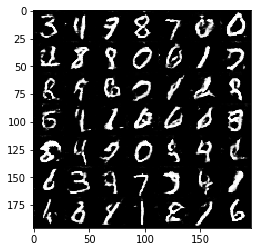

Epoch 1/5... Discriminator Loss: 1.8600... Generator Loss: 0.2450
Epoch 1/5... Discriminator Loss: 1.5137... Generator Loss: 0.6865
Epoch 1/5... Discriminator Loss: 1.5154... Generator Loss: 0.3592
Epoch 1/5... Discriminator Loss: 1.3945... Generator Loss: 0.5436
Epoch 1/5... Discriminator Loss: 1.6432... Generator Loss: 0.4096
Epoch 1/5... Discriminator Loss: 1.4427... Generator Loss: 0.5466
Epoch 1/5... Discriminator Loss: 1.5241... Generator Loss: 0.4934
Epoch 1/5... Discriminator Loss: 1.4376... Generator Loss: 0.5023
Epoch 1/5... Discriminator Loss: 1.4325... Generator Loss: 0.7086
Epoch 1/5... Discriminator Loss: 1.2217... Generator Loss: 0.7293


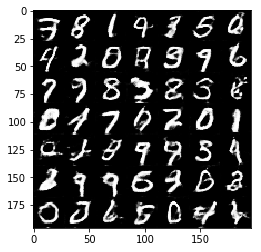

Epoch 1/5... Discriminator Loss: 1.7032... Generator Loss: 0.3293
Epoch 1/5... Discriminator Loss: 1.4244... Generator Loss: 0.5246
Epoch 1/5... Discriminator Loss: 1.5035... Generator Loss: 1.0192
Epoch 2/5... Discriminator Loss: 1.8424... Generator Loss: 0.2156
Epoch 2/5... Discriminator Loss: 1.5825... Generator Loss: 0.3642
Epoch 2/5... Discriminator Loss: 1.4357... Generator Loss: 0.5511
Epoch 2/5... Discriminator Loss: 1.4039... Generator Loss: 0.5014
Epoch 2/5... Discriminator Loss: 1.4280... Generator Loss: 0.5229
Epoch 2/5... Discriminator Loss: 1.5300... Generator Loss: 0.4162
Epoch 2/5... Discriminator Loss: 1.2802... Generator Loss: 0.9926


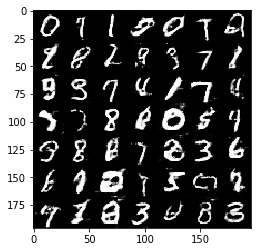

Epoch 2/5... Discriminator Loss: 1.5922... Generator Loss: 0.4702
Epoch 2/5... Discriminator Loss: 1.4328... Generator Loss: 0.9888
Epoch 2/5... Discriminator Loss: 1.5509... Generator Loss: 0.4756
Epoch 2/5... Discriminator Loss: 1.6925... Generator Loss: 0.3756
Epoch 2/5... Discriminator Loss: 1.2680... Generator Loss: 0.9034
Epoch 2/5... Discriminator Loss: 1.3459... Generator Loss: 0.4677
Epoch 2/5... Discriminator Loss: 1.6430... Generator Loss: 0.2992
Epoch 2/5... Discriminator Loss: 1.4556... Generator Loss: 0.9346
Epoch 2/5... Discriminator Loss: 1.4501... Generator Loss: 0.4754
Epoch 2/5... Discriminator Loss: 1.7612... Generator Loss: 0.2636


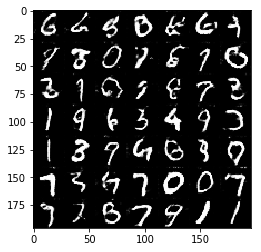

Epoch 2/5... Discriminator Loss: 1.2706... Generator Loss: 0.7688
Epoch 2/5... Discriminator Loss: 1.2956... Generator Loss: 0.5093
Epoch 2/5... Discriminator Loss: 1.4579... Generator Loss: 0.4027
Epoch 2/5... Discriminator Loss: 1.7461... Generator Loss: 0.2648
Epoch 2/5... Discriminator Loss: 1.5952... Generator Loss: 0.3817
Epoch 2/5... Discriminator Loss: 1.4978... Generator Loss: 0.4220
Epoch 2/5... Discriminator Loss: 1.2640... Generator Loss: 0.8812
Epoch 2/5... Discriminator Loss: 1.2804... Generator Loss: 0.6533
Epoch 2/5... Discriminator Loss: 1.4135... Generator Loss: 0.5336
Epoch 2/5... Discriminator Loss: 2.1901... Generator Loss: 0.1615


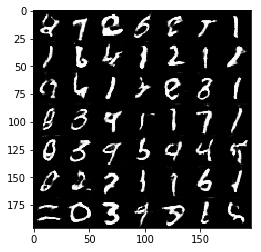

Epoch 2/5... Discriminator Loss: 2.1887... Generator Loss: 0.1566
Epoch 2/5... Discriminator Loss: 1.3306... Generator Loss: 0.5287
Epoch 2/5... Discriminator Loss: 1.4657... Generator Loss: 0.3827
Epoch 2/5... Discriminator Loss: 1.3738... Generator Loss: 0.5749
Epoch 2/5... Discriminator Loss: 1.3160... Generator Loss: 0.5030
Epoch 2/5... Discriminator Loss: 1.6757... Generator Loss: 0.3152
Epoch 2/5... Discriminator Loss: 1.3452... Generator Loss: 0.8667
Epoch 2/5... Discriminator Loss: 1.0954... Generator Loss: 0.8632
Epoch 2/5... Discriminator Loss: 1.2923... Generator Loss: 1.5644
Epoch 2/5... Discriminator Loss: 1.6218... Generator Loss: 0.2940


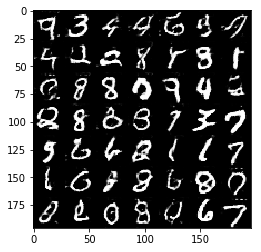

Epoch 2/5... Discriminator Loss: 1.4828... Generator Loss: 0.8051
Epoch 2/5... Discriminator Loss: 1.3959... Generator Loss: 0.6332
Epoch 2/5... Discriminator Loss: 1.6370... Generator Loss: 0.6651
Epoch 2/5... Discriminator Loss: 1.5727... Generator Loss: 0.4555
Epoch 2/5... Discriminator Loss: 1.3140... Generator Loss: 0.4883
Epoch 2/5... Discriminator Loss: 1.5443... Generator Loss: 1.1872
Epoch 2/5... Discriminator Loss: 1.6510... Generator Loss: 0.3517
Epoch 2/5... Discriminator Loss: 1.6889... Generator Loss: 0.2984
Epoch 2/5... Discriminator Loss: 1.3268... Generator Loss: 0.5833
Epoch 2/5... Discriminator Loss: 1.2538... Generator Loss: 0.6894


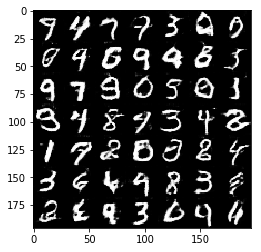

Epoch 2/5... Discriminator Loss: 1.9034... Generator Loss: 0.2318
Epoch 2/5... Discriminator Loss: 1.9595... Generator Loss: 0.2535
Epoch 2/5... Discriminator Loss: 1.4098... Generator Loss: 0.5401
Epoch 2/5... Discriminator Loss: 1.4894... Generator Loss: 0.7020
Epoch 2/5... Discriminator Loss: 1.3888... Generator Loss: 1.3581
Epoch 2/5... Discriminator Loss: 1.3836... Generator Loss: 0.5147
Epoch 2/5... Discriminator Loss: 1.4543... Generator Loss: 0.4917
Epoch 2/5... Discriminator Loss: 1.2948... Generator Loss: 0.6776
Epoch 2/5... Discriminator Loss: 1.4205... Generator Loss: 0.5734
Epoch 2/5... Discriminator Loss: 1.3777... Generator Loss: 0.5315


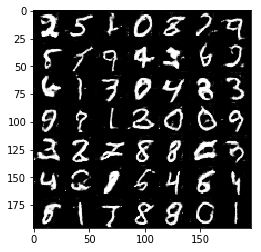

Epoch 2/5... Discriminator Loss: 1.3856... Generator Loss: 0.6546
Epoch 2/5... Discriminator Loss: 1.7887... Generator Loss: 0.2602
Epoch 2/5... Discriminator Loss: 1.5696... Generator Loss: 0.3753
Epoch 2/5... Discriminator Loss: 1.0701... Generator Loss: 0.7351
Epoch 2/5... Discriminator Loss: 1.4912... Generator Loss: 0.3727
Epoch 2/5... Discriminator Loss: 1.6464... Generator Loss: 0.3380
Epoch 2/5... Discriminator Loss: 1.4439... Generator Loss: 0.4094
Epoch 2/5... Discriminator Loss: 1.2237... Generator Loss: 1.0077
Epoch 2/5... Discriminator Loss: 1.2483... Generator Loss: 0.7927
Epoch 2/5... Discriminator Loss: 1.6097... Generator Loss: 1.8838


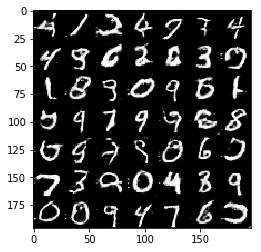

Epoch 2/5... Discriminator Loss: 1.4255... Generator Loss: 0.4036
Epoch 2/5... Discriminator Loss: 1.4054... Generator Loss: 0.4477
Epoch 2/5... Discriminator Loss: 1.3283... Generator Loss: 0.7575
Epoch 2/5... Discriminator Loss: 0.9696... Generator Loss: 1.0628
Epoch 2/5... Discriminator Loss: 1.1500... Generator Loss: 0.8233
Epoch 2/5... Discriminator Loss: 1.2008... Generator Loss: 0.7140
Epoch 2/5... Discriminator Loss: 0.9945... Generator Loss: 1.0584
Epoch 2/5... Discriminator Loss: 1.2581... Generator Loss: 0.7563
Epoch 2/5... Discriminator Loss: 1.2602... Generator Loss: 0.6118
Epoch 2/5... Discriminator Loss: 1.7945... Generator Loss: 0.2371


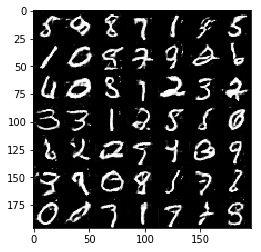

Epoch 2/5... Discriminator Loss: 1.7660... Generator Loss: 0.2879
Epoch 2/5... Discriminator Loss: 1.4227... Generator Loss: 0.6468
Epoch 2/5... Discriminator Loss: 2.4400... Generator Loss: 0.1290
Epoch 2/5... Discriminator Loss: 1.7001... Generator Loss: 0.2699
Epoch 2/5... Discriminator Loss: 1.1375... Generator Loss: 0.8931
Epoch 2/5... Discriminator Loss: 1.4722... Generator Loss: 0.3857
Epoch 2/5... Discriminator Loss: 2.6684... Generator Loss: 0.1042
Epoch 2/5... Discriminator Loss: 1.5112... Generator Loss: 0.3817
Epoch 2/5... Discriminator Loss: 1.1256... Generator Loss: 1.2610
Epoch 2/5... Discriminator Loss: 1.2417... Generator Loss: 0.5917


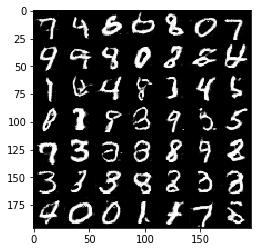

Epoch 2/5... Discriminator Loss: 1.7383... Generator Loss: 0.4688
Epoch 2/5... Discriminator Loss: 1.1113... Generator Loss: 0.6583
Epoch 2/5... Discriminator Loss: 1.7219... Generator Loss: 0.3065
Epoch 2/5... Discriminator Loss: 1.2597... Generator Loss: 0.7173
Epoch 2/5... Discriminator Loss: 1.2036... Generator Loss: 1.2252
Epoch 2/5... Discriminator Loss: 0.8236... Generator Loss: 1.1129
Epoch 2/5... Discriminator Loss: 2.3825... Generator Loss: 0.1375
Epoch 3/5... Discriminator Loss: 1.6571... Generator Loss: 0.3259
Epoch 3/5... Discriminator Loss: 2.0013... Generator Loss: 0.3246
Epoch 3/5... Discriminator Loss: 1.1728... Generator Loss: 1.3927


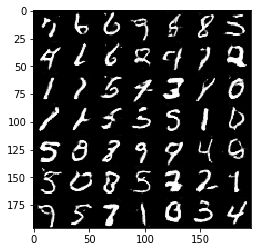

Epoch 3/5... Discriminator Loss: 1.3011... Generator Loss: 0.4229
Epoch 3/5... Discriminator Loss: 2.0071... Generator Loss: 0.2196
Epoch 3/5... Discriminator Loss: 1.2998... Generator Loss: 0.4820
Epoch 3/5... Discriminator Loss: 1.5269... Generator Loss: 0.3690
Epoch 3/5... Discriminator Loss: 1.0678... Generator Loss: 0.9131
Epoch 3/5... Discriminator Loss: 1.0242... Generator Loss: 0.8712
Epoch 3/5... Discriminator Loss: 1.5526... Generator Loss: 0.3808
Epoch 3/5... Discriminator Loss: 1.5680... Generator Loss: 0.3874
Epoch 3/5... Discriminator Loss: 1.4718... Generator Loss: 0.4619
Epoch 3/5... Discriminator Loss: 1.2586... Generator Loss: 0.6500


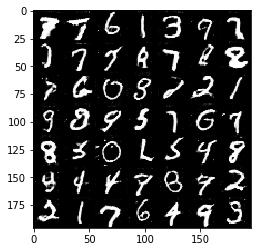

Epoch 3/5... Discriminator Loss: 1.7057... Generator Loss: 0.4298
Epoch 3/5... Discriminator Loss: 0.8342... Generator Loss: 0.9689
Epoch 3/5... Discriminator Loss: 1.7850... Generator Loss: 0.2856
Epoch 3/5... Discriminator Loss: 1.5440... Generator Loss: 0.4021
Epoch 3/5... Discriminator Loss: 2.0465... Generator Loss: 0.1986
Epoch 3/5... Discriminator Loss: 1.5674... Generator Loss: 0.3903
Epoch 3/5... Discriminator Loss: 2.8046... Generator Loss: 0.0812
Epoch 3/5... Discriminator Loss: 1.7174... Generator Loss: 0.2990
Epoch 3/5... Discriminator Loss: 1.4589... Generator Loss: 0.3938
Epoch 3/5... Discriminator Loss: 1.4100... Generator Loss: 0.4726


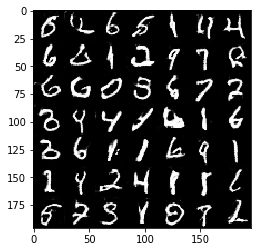

Epoch 3/5... Discriminator Loss: 2.7843... Generator Loss: 0.1107
Epoch 3/5... Discriminator Loss: 0.9181... Generator Loss: 1.0362
Epoch 3/5... Discriminator Loss: 1.2894... Generator Loss: 0.6892
Epoch 3/5... Discriminator Loss: 1.3804... Generator Loss: 0.4152
Epoch 3/5... Discriminator Loss: 2.4608... Generator Loss: 0.1419
Epoch 3/5... Discriminator Loss: 2.2061... Generator Loss: 0.1705
Epoch 3/5... Discriminator Loss: 1.3109... Generator Loss: 1.1091
Epoch 3/5... Discriminator Loss: 1.8652... Generator Loss: 0.2437
Epoch 3/5... Discriminator Loss: 1.6936... Generator Loss: 0.6514
Epoch 3/5... Discriminator Loss: 1.4472... Generator Loss: 0.4111


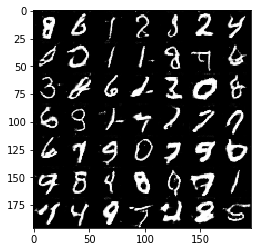

Epoch 3/5... Discriminator Loss: 1.0375... Generator Loss: 0.6921
Epoch 3/5... Discriminator Loss: 0.7120... Generator Loss: 1.1082
Epoch 3/5... Discriminator Loss: 1.1397... Generator Loss: 0.6410
Epoch 3/5... Discriminator Loss: 1.5944... Generator Loss: 0.3650
Epoch 3/5... Discriminator Loss: 1.0123... Generator Loss: 0.7295
Epoch 3/5... Discriminator Loss: 1.3448... Generator Loss: 0.5564
Epoch 3/5... Discriminator Loss: 1.3097... Generator Loss: 2.2015
Epoch 3/5... Discriminator Loss: 1.3309... Generator Loss: 0.5409
Epoch 3/5... Discriminator Loss: 2.3829... Generator Loss: 0.1597
Epoch 3/5... Discriminator Loss: 0.7268... Generator Loss: 1.0184


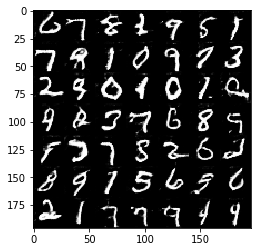

Epoch 3/5... Discriminator Loss: 1.1130... Generator Loss: 0.7854
Epoch 3/5... Discriminator Loss: 2.3637... Generator Loss: 0.2339
Epoch 3/5... Discriminator Loss: 0.9441... Generator Loss: 1.2649
Epoch 3/5... Discriminator Loss: 1.0784... Generator Loss: 1.4913
Epoch 3/5... Discriminator Loss: 1.2813... Generator Loss: 0.4924
Epoch 3/5... Discriminator Loss: 1.8647... Generator Loss: 2.9132
Epoch 3/5... Discriminator Loss: 0.9665... Generator Loss: 0.9124
Epoch 3/5... Discriminator Loss: 1.7144... Generator Loss: 1.6916
Epoch 3/5... Discriminator Loss: 1.2037... Generator Loss: 0.6001
Epoch 3/5... Discriminator Loss: 1.7194... Generator Loss: 0.3041


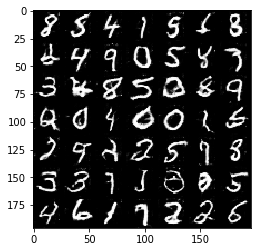

Epoch 3/5... Discriminator Loss: 1.2471... Generator Loss: 0.8987
Epoch 3/5... Discriminator Loss: 2.2114... Generator Loss: 0.1612
Epoch 3/5... Discriminator Loss: 1.0495... Generator Loss: 1.5812
Epoch 3/5... Discriminator Loss: 0.9372... Generator Loss: 1.0467
Epoch 3/5... Discriminator Loss: 1.8103... Generator Loss: 0.2699
Epoch 3/5... Discriminator Loss: 0.7850... Generator Loss: 0.9539
Epoch 3/5... Discriminator Loss: 1.9972... Generator Loss: 0.2264
Epoch 3/5... Discriminator Loss: 2.6972... Generator Loss: 0.1065
Epoch 3/5... Discriminator Loss: 1.0697... Generator Loss: 0.8157
Epoch 3/5... Discriminator Loss: 1.4842... Generator Loss: 0.4250


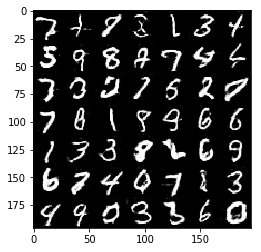

Epoch 3/5... Discriminator Loss: 1.1534... Generator Loss: 0.5823
Epoch 3/5... Discriminator Loss: 1.0448... Generator Loss: 1.1864
Epoch 3/5... Discriminator Loss: 1.0728... Generator Loss: 1.0374
Epoch 3/5... Discriminator Loss: 2.1201... Generator Loss: 0.1977
Epoch 3/5... Discriminator Loss: 1.1950... Generator Loss: 2.3308
Epoch 3/5... Discriminator Loss: 1.1527... Generator Loss: 0.6830
Epoch 3/5... Discriminator Loss: 0.8317... Generator Loss: 0.9521
Epoch 3/5... Discriminator Loss: 1.7507... Generator Loss: 0.3288
Epoch 3/5... Discriminator Loss: 0.5674... Generator Loss: 1.5600
Epoch 3/5... Discriminator Loss: 1.0697... Generator Loss: 0.9675


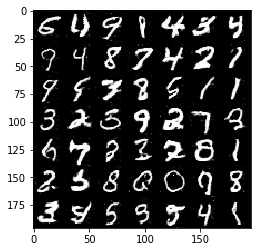

Epoch 3/5... Discriminator Loss: 1.2479... Generator Loss: 1.7992
Epoch 3/5... Discriminator Loss: 1.2957... Generator Loss: 0.5110
Epoch 3/5... Discriminator Loss: 1.3455... Generator Loss: 0.9181
Epoch 3/5... Discriminator Loss: 2.0270... Generator Loss: 0.2284
Epoch 3/5... Discriminator Loss: 2.5654... Generator Loss: 0.1247
Epoch 3/5... Discriminator Loss: 1.1855... Generator Loss: 0.6245
Epoch 3/5... Discriminator Loss: 2.0657... Generator Loss: 0.2092
Epoch 3/5... Discriminator Loss: 1.4283... Generator Loss: 0.4594
Epoch 3/5... Discriminator Loss: 1.4447... Generator Loss: 0.7955
Epoch 3/5... Discriminator Loss: 2.4678... Generator Loss: 0.1360


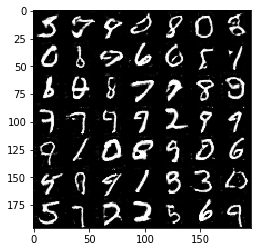

Epoch 3/5... Discriminator Loss: 1.5223... Generator Loss: 0.3719
Epoch 3/5... Discriminator Loss: 1.3538... Generator Loss: 0.4776
Epoch 3/5... Discriminator Loss: 1.5730... Generator Loss: 0.4385
Epoch 3/5... Discriminator Loss: 0.9277... Generator Loss: 0.7647
Epoch 3/5... Discriminator Loss: 1.7594... Generator Loss: 0.2818
Epoch 3/5... Discriminator Loss: 1.4625... Generator Loss: 0.4491
Epoch 3/5... Discriminator Loss: 1.1744... Generator Loss: 1.9277
Epoch 3/5... Discriminator Loss: 1.1210... Generator Loss: 1.2281
Epoch 3/5... Discriminator Loss: 1.5104... Generator Loss: 0.3947
Epoch 3/5... Discriminator Loss: 1.6546... Generator Loss: 0.3375


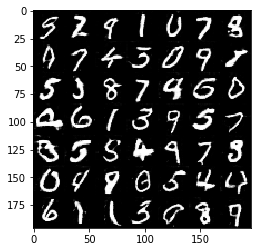

Epoch 3/5... Discriminator Loss: 1.5939... Generator Loss: 0.3332
Epoch 4/5... Discriminator Loss: 1.7129... Generator Loss: 1.1241
Epoch 4/5... Discriminator Loss: 1.0382... Generator Loss: 0.6806
Epoch 4/5... Discriminator Loss: 1.5178... Generator Loss: 0.3382
Epoch 4/5... Discriminator Loss: 1.4319... Generator Loss: 1.4317
Epoch 4/5... Discriminator Loss: 1.1213... Generator Loss: 0.7351
Epoch 4/5... Discriminator Loss: 2.0065... Generator Loss: 0.2140
Epoch 4/5... Discriminator Loss: 2.0214... Generator Loss: 0.2083
Epoch 4/5... Discriminator Loss: 1.0846... Generator Loss: 0.7253
Epoch 4/5... Discriminator Loss: 0.4129... Generator Loss: 1.7524


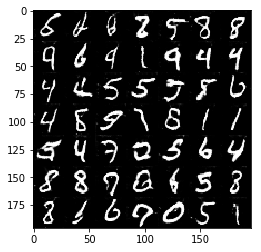

Epoch 4/5... Discriminator Loss: 2.3460... Generator Loss: 0.2625
Epoch 4/5... Discriminator Loss: 1.0671... Generator Loss: 0.9388
Epoch 4/5... Discriminator Loss: 0.9551... Generator Loss: 0.8340
Epoch 4/5... Discriminator Loss: 0.9675... Generator Loss: 0.8654
Epoch 4/5... Discriminator Loss: 2.1335... Generator Loss: 0.1797
Epoch 4/5... Discriminator Loss: 1.2730... Generator Loss: 0.5309
Epoch 4/5... Discriminator Loss: 0.8851... Generator Loss: 0.7159
Epoch 4/5... Discriminator Loss: 1.2548... Generator Loss: 2.3338
Epoch 4/5... Discriminator Loss: 1.0151... Generator Loss: 0.7268
Epoch 4/5... Discriminator Loss: 1.4587... Generator Loss: 0.5726


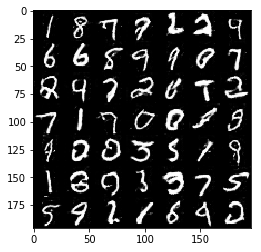

Epoch 4/5... Discriminator Loss: 0.7922... Generator Loss: 1.0555
Epoch 4/5... Discriminator Loss: 2.3485... Generator Loss: 0.1641
Epoch 4/5... Discriminator Loss: 0.6146... Generator Loss: 1.3341
Epoch 4/5... Discriminator Loss: 1.0565... Generator Loss: 0.6277
Epoch 4/5... Discriminator Loss: 2.0751... Generator Loss: 0.1827
Epoch 4/5... Discriminator Loss: 0.8791... Generator Loss: 0.8512
Epoch 4/5... Discriminator Loss: 1.0325... Generator Loss: 0.6774
Epoch 4/5... Discriminator Loss: 1.8075... Generator Loss: 0.3055
Epoch 4/5... Discriminator Loss: 1.5061... Generator Loss: 0.3917
Epoch 4/5... Discriminator Loss: 1.4164... Generator Loss: 0.4745


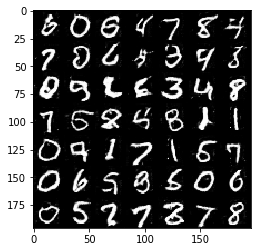

Epoch 4/5... Discriminator Loss: 0.9854... Generator Loss: 0.8543
Epoch 4/5... Discriminator Loss: 1.5403... Generator Loss: 0.4204
Epoch 4/5... Discriminator Loss: 1.4430... Generator Loss: 0.3785
Epoch 4/5... Discriminator Loss: 0.9680... Generator Loss: 0.8622
Epoch 4/5... Discriminator Loss: 1.2529... Generator Loss: 0.4878
Epoch 4/5... Discriminator Loss: 0.4263... Generator Loss: 1.9384
Epoch 4/5... Discriminator Loss: 2.7254... Generator Loss: 0.1660
Epoch 4/5... Discriminator Loss: 0.6414... Generator Loss: 1.2662
Epoch 4/5... Discriminator Loss: 1.1644... Generator Loss: 0.5957
Epoch 4/5... Discriminator Loss: 0.1208... Generator Loss: 4.0541


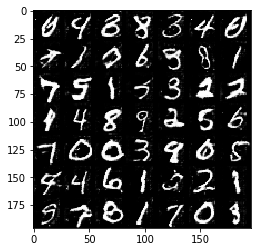

Epoch 4/5... Discriminator Loss: 1.2902... Generator Loss: 0.5001
Epoch 4/5... Discriminator Loss: 1.6905... Generator Loss: 2.4771
Epoch 4/5... Discriminator Loss: 1.2535... Generator Loss: 0.4701
Epoch 4/5... Discriminator Loss: 1.7770... Generator Loss: 0.2605
Epoch 4/5... Discriminator Loss: 2.8766... Generator Loss: 0.1251
Epoch 4/5... Discriminator Loss: 1.7654... Generator Loss: 0.2794
Epoch 4/5... Discriminator Loss: 1.1467... Generator Loss: 0.6234
Epoch 4/5... Discriminator Loss: 1.7538... Generator Loss: 0.3365
Epoch 4/5... Discriminator Loss: 1.4357... Generator Loss: 0.4026
Epoch 4/5... Discriminator Loss: 1.5747... Generator Loss: 0.3590


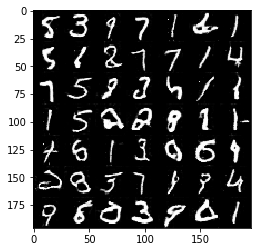

Epoch 4/5... Discriminator Loss: 2.0384... Generator Loss: 0.2066
Epoch 4/5... Discriminator Loss: 1.4228... Generator Loss: 0.4846
Epoch 4/5... Discriminator Loss: 2.4583... Generator Loss: 0.1169
Epoch 4/5... Discriminator Loss: 1.4905... Generator Loss: 0.4385
Epoch 4/5... Discriminator Loss: 1.3606... Generator Loss: 0.4908
Epoch 4/5... Discriminator Loss: 2.5184... Generator Loss: 0.1910
Epoch 4/5... Discriminator Loss: 0.9092... Generator Loss: 1.3609
Epoch 4/5... Discriminator Loss: 2.1696... Generator Loss: 0.2280
Epoch 4/5... Discriminator Loss: 1.2906... Generator Loss: 0.5733
Epoch 4/5... Discriminator Loss: 1.1705... Generator Loss: 1.0256


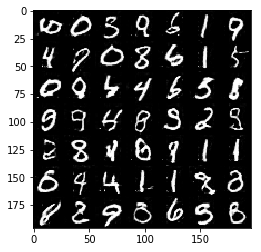

Epoch 4/5... Discriminator Loss: 1.5780... Generator Loss: 0.7452
Epoch 4/5... Discriminator Loss: 1.3433... Generator Loss: 0.4977
Epoch 4/5... Discriminator Loss: 0.5441... Generator Loss: 1.1856
Epoch 4/5... Discriminator Loss: 1.8694... Generator Loss: 0.2757
Epoch 4/5... Discriminator Loss: 2.7004... Generator Loss: 0.1308
Epoch 4/5... Discriminator Loss: 0.8220... Generator Loss: 0.8266
Epoch 4/5... Discriminator Loss: 1.6185... Generator Loss: 0.3228
Epoch 4/5... Discriminator Loss: 2.3134... Generator Loss: 1.4610
Epoch 4/5... Discriminator Loss: 0.9995... Generator Loss: 1.8689
Epoch 4/5... Discriminator Loss: 1.6884... Generator Loss: 0.3563


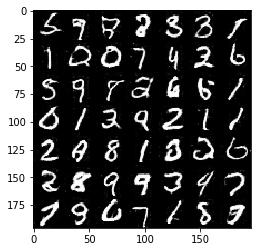

Epoch 4/5... Discriminator Loss: 1.8771... Generator Loss: 0.2518
Epoch 4/5... Discriminator Loss: 0.6616... Generator Loss: 1.4201
Epoch 4/5... Discriminator Loss: 2.1546... Generator Loss: 0.1851
Epoch 4/5... Discriminator Loss: 1.6282... Generator Loss: 0.4172
Epoch 4/5... Discriminator Loss: 1.3017... Generator Loss: 0.4481
Epoch 4/5... Discriminator Loss: 1.8152... Generator Loss: 0.3228
Epoch 4/5... Discriminator Loss: 1.0984... Generator Loss: 1.6676
Epoch 4/5... Discriminator Loss: 1.3061... Generator Loss: 1.0385
Epoch 4/5... Discriminator Loss: 1.6083... Generator Loss: 0.3976
Epoch 4/5... Discriminator Loss: 2.1144... Generator Loss: 0.2134


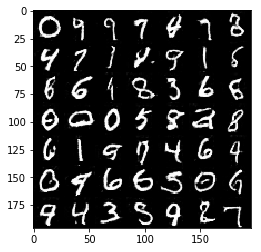

Epoch 4/5... Discriminator Loss: 2.2069... Generator Loss: 0.2141
Epoch 4/5... Discriminator Loss: 0.9006... Generator Loss: 0.8467
Epoch 4/5... Discriminator Loss: 1.0573... Generator Loss: 1.5285
Epoch 4/5... Discriminator Loss: 1.0579... Generator Loss: 0.6460
Epoch 4/5... Discriminator Loss: 1.9749... Generator Loss: 0.2945
Epoch 4/5... Discriminator Loss: 0.9403... Generator Loss: 0.9879
Epoch 4/5... Discriminator Loss: 1.5429... Generator Loss: 0.4025
Epoch 4/5... Discriminator Loss: 1.6544... Generator Loss: 0.3485
Epoch 4/5... Discriminator Loss: 1.4171... Generator Loss: 0.4992
Epoch 4/5... Discriminator Loss: 0.8767... Generator Loss: 0.9629


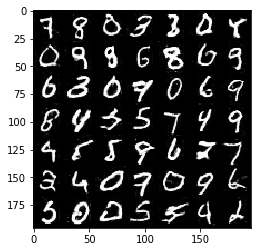

Epoch 4/5... Discriminator Loss: 1.1963... Generator Loss: 0.6726
Epoch 4/5... Discriminator Loss: 1.2885... Generator Loss: 0.5118
Epoch 4/5... Discriminator Loss: 1.2453... Generator Loss: 0.5479
Epoch 4/5... Discriminator Loss: 1.2619... Generator Loss: 0.5160
Epoch 5/5... Discriminator Loss: 1.9842... Generator Loss: 0.2644
Epoch 5/5... Discriminator Loss: 1.1279... Generator Loss: 1.9328
Epoch 5/5... Discriminator Loss: 0.9688... Generator Loss: 0.7500
Epoch 5/5... Discriminator Loss: 1.3432... Generator Loss: 0.6177
Epoch 5/5... Discriminator Loss: 0.7676... Generator Loss: 0.9980
Epoch 5/5... Discriminator Loss: 2.6992... Generator Loss: 0.1194


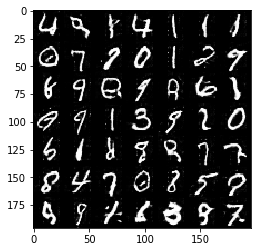

Epoch 5/5... Discriminator Loss: 1.5216... Generator Loss: 0.3869
Epoch 5/5... Discriminator Loss: 1.4584... Generator Loss: 0.4448
Epoch 5/5... Discriminator Loss: 1.8455... Generator Loss: 0.2636
Epoch 5/5... Discriminator Loss: 1.6522... Generator Loss: 0.4059
Epoch 5/5... Discriminator Loss: 1.3578... Generator Loss: 0.4978
Epoch 5/5... Discriminator Loss: 0.2739... Generator Loss: 2.5420
Epoch 5/5... Discriminator Loss: 1.7791... Generator Loss: 0.2879
Epoch 5/5... Discriminator Loss: 1.6317... Generator Loss: 0.3013
Epoch 5/5... Discriminator Loss: 1.6436... Generator Loss: 0.3380
Epoch 5/5... Discriminator Loss: 0.8176... Generator Loss: 1.2779


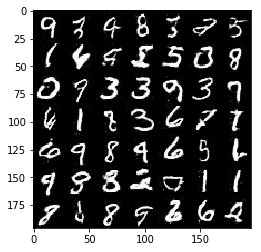

Epoch 5/5... Discriminator Loss: 1.2927... Generator Loss: 0.7374
Epoch 5/5... Discriminator Loss: 0.8052... Generator Loss: 2.7452
Epoch 5/5... Discriminator Loss: 3.3483... Generator Loss: 0.0652
Epoch 5/5... Discriminator Loss: 1.4282... Generator Loss: 0.4297
Epoch 5/5... Discriminator Loss: 1.1082... Generator Loss: 1.1446
Epoch 5/5... Discriminator Loss: 1.8273... Generator Loss: 0.2980
Epoch 5/5... Discriminator Loss: 1.2372... Generator Loss: 0.5452
Epoch 5/5... Discriminator Loss: 1.5812... Generator Loss: 0.5041
Epoch 5/5... Discriminator Loss: 1.2716... Generator Loss: 0.4898
Epoch 5/5... Discriminator Loss: 1.0886... Generator Loss: 0.7707


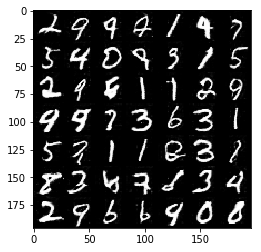

Epoch 5/5... Discriminator Loss: 0.9414... Generator Loss: 4.7611
Epoch 5/5... Discriminator Loss: 1.0704... Generator Loss: 1.7499
Epoch 5/5... Discriminator Loss: 1.2207... Generator Loss: 0.7467
Epoch 5/5... Discriminator Loss: 2.0842... Generator Loss: 0.3227
Epoch 5/5... Discriminator Loss: 2.8088... Generator Loss: 2.9198
Epoch 5/5... Discriminator Loss: 1.1819... Generator Loss: 0.5690
Epoch 5/5... Discriminator Loss: 1.4451... Generator Loss: 0.3942
Epoch 5/5... Discriminator Loss: 2.0893... Generator Loss: 0.1983
Epoch 5/5... Discriminator Loss: 1.3924... Generator Loss: 0.4644
Epoch 5/5... Discriminator Loss: 1.2381... Generator Loss: 0.6712


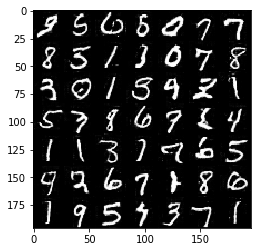

Epoch 5/5... Discriminator Loss: 2.0727... Generator Loss: 0.2498
Epoch 5/5... Discriminator Loss: 2.6869... Generator Loss: 0.1114
Epoch 5/5... Discriminator Loss: 2.1500... Generator Loss: 0.2358
Epoch 5/5... Discriminator Loss: 2.2306... Generator Loss: 0.2118
Epoch 5/5... Discriminator Loss: 1.5520... Generator Loss: 0.4293
Epoch 5/5... Discriminator Loss: 2.6935... Generator Loss: 0.1296
Epoch 5/5... Discriminator Loss: 1.7864... Generator Loss: 0.2658
Epoch 5/5... Discriminator Loss: 1.8939... Generator Loss: 0.3175
Epoch 5/5... Discriminator Loss: 0.0937... Generator Loss: 3.6416
Epoch 5/5... Discriminator Loss: 1.7898... Generator Loss: 0.2792


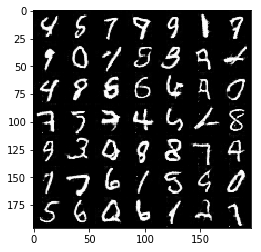

Epoch 5/5... Discriminator Loss: 2.0902... Generator Loss: 0.2719
Epoch 5/5... Discriminator Loss: 2.7510... Generator Loss: 0.1022
Epoch 5/5... Discriminator Loss: 2.4065... Generator Loss: 0.1970
Epoch 5/5... Discriminator Loss: 1.9573... Generator Loss: 1.0420
Epoch 5/5... Discriminator Loss: 1.1024... Generator Loss: 0.8012
Epoch 5/5... Discriminator Loss: 0.8205... Generator Loss: 1.1022
Epoch 5/5... Discriminator Loss: 2.1724... Generator Loss: 0.1972
Epoch 5/5... Discriminator Loss: 1.5922... Generator Loss: 0.4054
Epoch 5/5... Discriminator Loss: 1.9230... Generator Loss: 0.2514
Epoch 5/5... Discriminator Loss: 1.5396... Generator Loss: 0.5649


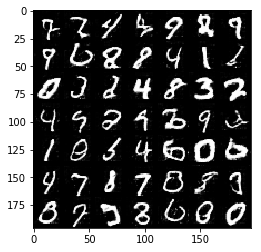

Epoch 5/5... Discriminator Loss: 2.3907... Generator Loss: 0.1606
Epoch 5/5... Discriminator Loss: 0.8000... Generator Loss: 0.9870
Epoch 5/5... Discriminator Loss: 1.6539... Generator Loss: 0.3451
Epoch 5/5... Discriminator Loss: 1.7536... Generator Loss: 0.3167
Epoch 5/5... Discriminator Loss: 2.7436... Generator Loss: 0.1912
Epoch 5/5... Discriminator Loss: 1.3517... Generator Loss: 0.4263
Epoch 5/5... Discriminator Loss: 0.9170... Generator Loss: 0.8794
Epoch 5/5... Discriminator Loss: 1.3346... Generator Loss: 0.5420
Epoch 5/5... Discriminator Loss: 1.6265... Generator Loss: 0.3816
Epoch 5/5... Discriminator Loss: 1.7297... Generator Loss: 0.3575


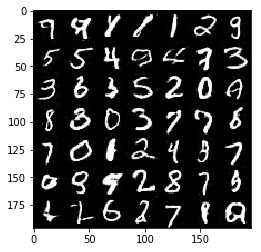

Epoch 5/5... Discriminator Loss: 1.3130... Generator Loss: 0.5119
Epoch 5/5... Discriminator Loss: 1.2251... Generator Loss: 0.5349
Epoch 5/5... Discriminator Loss: 0.6962... Generator Loss: 2.4192
Epoch 5/5... Discriminator Loss: 1.3355... Generator Loss: 0.4585
Epoch 5/5... Discriminator Loss: 1.1259... Generator Loss: 0.6170
Epoch 5/5... Discriminator Loss: 0.9618... Generator Loss: 1.5885
Epoch 5/5... Discriminator Loss: 1.8666... Generator Loss: 0.2487
Epoch 5/5... Discriminator Loss: 1.4036... Generator Loss: 0.3997
Epoch 5/5... Discriminator Loss: 1.8680... Generator Loss: 0.2931
Epoch 5/5... Discriminator Loss: 1.7165... Generator Loss: 0.3196


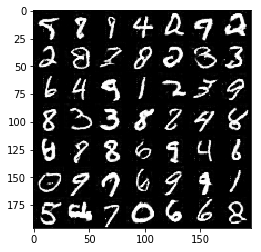

Epoch 5/5... Discriminator Loss: 0.1344... Generator Loss: 3.4230
Epoch 5/5... Discriminator Loss: 1.2873... Generator Loss: 0.5016
Epoch 5/5... Discriminator Loss: 0.6890... Generator Loss: 1.2670
Epoch 5/5... Discriminator Loss: 1.3540... Generator Loss: 0.4881
Epoch 5/5... Discriminator Loss: 1.6529... Generator Loss: 0.3677
Epoch 5/5... Discriminator Loss: 1.8245... Generator Loss: 0.2852
Epoch 5/5... Discriminator Loss: 1.5715... Generator Loss: 0.3702
Epoch 5/5... Discriminator Loss: 1.6920... Generator Loss: 0.3084
Epoch 5/5... Discriminator Loss: 0.9887... Generator Loss: 0.7908
Epoch 5/5... Discriminator Loss: 1.9250... Generator Loss: 0.2683


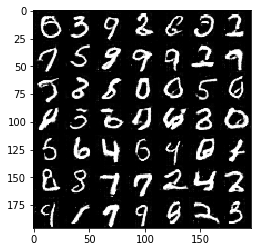

Epoch 5/5... Discriminator Loss: 1.8985... Generator Loss: 0.2361
Epoch 5/5... Discriminator Loss: 0.2732... Generator Loss: 2.0747
Epoch 5/5... Discriminator Loss: 0.8688... Generator Loss: 1.1830
Epoch 5/5... Discriminator Loss: 1.0481... Generator Loss: 0.7324
Epoch 5/5... Discriminator Loss: 0.8028... Generator Loss: 1.1011
Epoch 5/5... Discriminator Loss: 0.8002... Generator Loss: 2.3566
Epoch 5/5... Discriminator Loss: 0.7107... Generator Loss: 1.4059
Epoch 5/5... Discriminator Loss: 0.9998... Generator Loss: 0.7315


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 2.0404... Generator Loss: 1.2963
Epoch 1/2... Discriminator Loss: 2.5028... Generator Loss: 0.2053
Epoch 1/2... Discriminator Loss: 1.7884... Generator Loss: 0.9267
Epoch 1/2... Discriminator Loss: 2.6521... Generator Loss: 2.7543
Epoch 1/2... Discriminator Loss: 1.2893... Generator Loss: 2.5782
Epoch 1/2... Discriminator Loss: 2.3878... Generator Loss: 0.1675
Epoch 1/2... Discriminator Loss: 2.7255... Generator Loss: 0.1276
Epoch 1/2... Discriminator Loss: 2.5536... Generator Loss: 0.1293
Epoch 1/2... Discriminator Loss: 1.1854... Generator Loss: 0.9252
Epoch 1/2... Discriminator Loss: 2.3520... Generator Loss: 0.1921


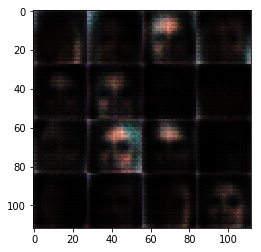

Epoch 1/2... Discriminator Loss: 1.2239... Generator Loss: 0.5709
Epoch 1/2... Discriminator Loss: 1.3592... Generator Loss: 1.5522
Epoch 1/2... Discriminator Loss: 1.3809... Generator Loss: 0.8397
Epoch 1/2... Discriminator Loss: 2.5554... Generator Loss: 0.2279
Epoch 1/2... Discriminator Loss: 2.4006... Generator Loss: 0.1668
Epoch 1/2... Discriminator Loss: 2.1172... Generator Loss: 0.2084
Epoch 1/2... Discriminator Loss: 1.5434... Generator Loss: 0.7317
Epoch 1/2... Discriminator Loss: 1.5497... Generator Loss: 0.6914
Epoch 1/2... Discriminator Loss: 1.5684... Generator Loss: 0.6137
Epoch 1/2... Discriminator Loss: 2.1613... Generator Loss: 0.2428


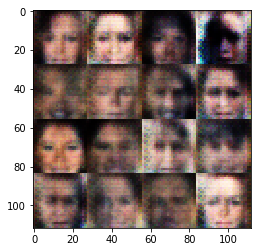

Epoch 1/2... Discriminator Loss: 2.1336... Generator Loss: 0.2272
Epoch 1/2... Discriminator Loss: 1.3252... Generator Loss: 1.3045
Epoch 1/2... Discriminator Loss: 1.8564... Generator Loss: 0.2724
Epoch 1/2... Discriminator Loss: 1.3700... Generator Loss: 0.6541
Epoch 1/2... Discriminator Loss: 1.4234... Generator Loss: 0.6834
Epoch 1/2... Discriminator Loss: 1.3169... Generator Loss: 1.0105
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 1.1844
Epoch 1/2... Discriminator Loss: 1.4906... Generator Loss: 0.4923
Epoch 1/2... Discriminator Loss: 1.2503... Generator Loss: 0.6791
Epoch 1/2... Discriminator Loss: 1.4700... Generator Loss: 0.5350


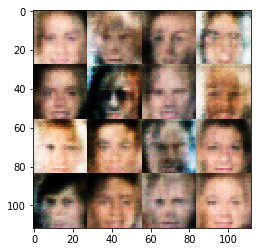

Epoch 1/2... Discriminator Loss: 1.0572... Generator Loss: 0.8150
Epoch 1/2... Discriminator Loss: 1.0267... Generator Loss: 2.5872
Epoch 1/2... Discriminator Loss: 1.4815... Generator Loss: 0.4125
Epoch 1/2... Discriminator Loss: 1.3416... Generator Loss: 0.6027
Epoch 1/2... Discriminator Loss: 1.6897... Generator Loss: 0.3325
Epoch 1/2... Discriminator Loss: 1.8536... Generator Loss: 0.2771
Epoch 1/2... Discriminator Loss: 1.5854... Generator Loss: 0.3281
Epoch 1/2... Discriminator Loss: 1.2190... Generator Loss: 0.9240
Epoch 1/2... Discriminator Loss: 1.2516... Generator Loss: 0.6237
Epoch 1/2... Discriminator Loss: 1.2310... Generator Loss: 0.5605


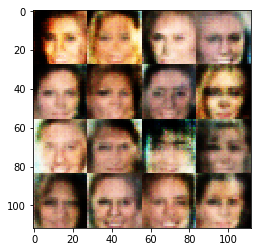

Epoch 1/2... Discriminator Loss: 1.0391... Generator Loss: 0.7859
Epoch 1/2... Discriminator Loss: 1.0141... Generator Loss: 1.9029
Epoch 1/2... Discriminator Loss: 1.5573... Generator Loss: 0.7939
Epoch 1/2... Discriminator Loss: 1.8153... Generator Loss: 0.3241
Epoch 1/2... Discriminator Loss: 2.0116... Generator Loss: 0.2222
Epoch 1/2... Discriminator Loss: 1.2993... Generator Loss: 0.9191
Epoch 1/2... Discriminator Loss: 1.0129... Generator Loss: 0.8136
Epoch 1/2... Discriminator Loss: 1.2328... Generator Loss: 0.7771
Epoch 1/2... Discriminator Loss: 1.1116... Generator Loss: 1.6437
Epoch 1/2... Discriminator Loss: 0.9980... Generator Loss: 1.1113


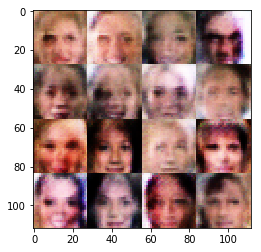

Epoch 1/2... Discriminator Loss: 1.2633... Generator Loss: 0.6863
Epoch 1/2... Discriminator Loss: 1.9264... Generator Loss: 0.2186
Epoch 1/2... Discriminator Loss: 1.3527... Generator Loss: 0.6749
Epoch 1/2... Discriminator Loss: 1.0446... Generator Loss: 0.8346
Epoch 1/2... Discriminator Loss: 2.0422... Generator Loss: 0.2094
Epoch 1/2... Discriminator Loss: 1.4828... Generator Loss: 0.5274
Epoch 1/2... Discriminator Loss: 0.9311... Generator Loss: 1.7136
Epoch 1/2... Discriminator Loss: 1.3535... Generator Loss: 1.1250
Epoch 1/2... Discriminator Loss: 1.2879... Generator Loss: 0.7089
Epoch 1/2... Discriminator Loss: 1.5687... Generator Loss: 0.3496


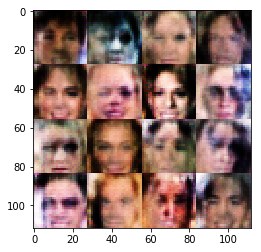

Epoch 1/2... Discriminator Loss: 0.8865... Generator Loss: 3.1801
Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 0.5832
Epoch 1/2... Discriminator Loss: 1.1575... Generator Loss: 1.4267
Epoch 1/2... Discriminator Loss: 1.1034... Generator Loss: 1.5393
Epoch 1/2... Discriminator Loss: 1.5894... Generator Loss: 0.5608
Epoch 1/2... Discriminator Loss: 1.1447... Generator Loss: 0.7348
Epoch 1/2... Discriminator Loss: 2.0575... Generator Loss: 0.2914
Epoch 1/2... Discriminator Loss: 1.5102... Generator Loss: 0.6149
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 0.6337
Epoch 1/2... Discriminator Loss: 1.6054... Generator Loss: 1.2767


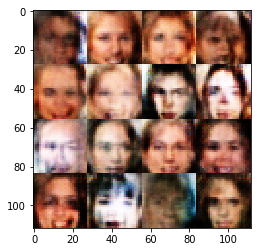

Epoch 1/2... Discriminator Loss: 0.8768... Generator Loss: 1.0619
Epoch 1/2... Discriminator Loss: 0.9392... Generator Loss: 1.4615
Epoch 1/2... Discriminator Loss: 1.1458... Generator Loss: 1.2999
Epoch 1/2... Discriminator Loss: 1.4086... Generator Loss: 0.6007
Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 1.0717
Epoch 1/2... Discriminator Loss: 2.0580... Generator Loss: 0.2764
Epoch 1/2... Discriminator Loss: 1.5469... Generator Loss: 0.3456
Epoch 1/2... Discriminator Loss: 1.3875... Generator Loss: 0.4066
Epoch 1/2... Discriminator Loss: 1.7976... Generator Loss: 1.5263
Epoch 1/2... Discriminator Loss: 1.7011... Generator Loss: 1.5534


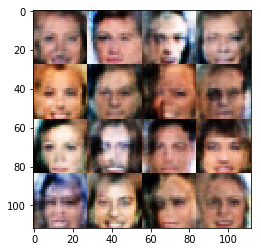

Epoch 1/2... Discriminator Loss: 0.8751... Generator Loss: 1.1301
Epoch 1/2... Discriminator Loss: 2.0184... Generator Loss: 0.1980
Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 0.7137
Epoch 1/2... Discriminator Loss: 1.2090... Generator Loss: 0.5338
Epoch 1/2... Discriminator Loss: 1.3548... Generator Loss: 0.5711
Epoch 1/2... Discriminator Loss: 1.1839... Generator Loss: 0.9308
Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 0.7554
Epoch 1/2... Discriminator Loss: 1.5974... Generator Loss: 0.4666
Epoch 1/2... Discriminator Loss: 1.6507... Generator Loss: 0.2813
Epoch 1/2... Discriminator Loss: 1.0625... Generator Loss: 1.1146


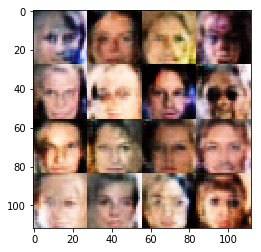

Epoch 1/2... Discriminator Loss: 1.3420... Generator Loss: 0.8048
Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.6439
Epoch 1/2... Discriminator Loss: 1.4327... Generator Loss: 0.6856
Epoch 1/2... Discriminator Loss: 0.8126... Generator Loss: 1.4136
Epoch 1/2... Discriminator Loss: 1.6781... Generator Loss: 0.3076
Epoch 1/2... Discriminator Loss: 1.7683... Generator Loss: 0.2836
Epoch 1/2... Discriminator Loss: 1.3239... Generator Loss: 0.6347
Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 0.5848
Epoch 1/2... Discriminator Loss: 1.2967... Generator Loss: 0.7894
Epoch 1/2... Discriminator Loss: 0.8491... Generator Loss: 1.1115


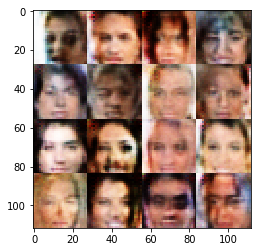

Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 0.9054
Epoch 1/2... Discriminator Loss: 1.8048... Generator Loss: 0.2407
Epoch 1/2... Discriminator Loss: 1.3979... Generator Loss: 1.4532
Epoch 1/2... Discriminator Loss: 1.4035... Generator Loss: 1.4672
Epoch 1/2... Discriminator Loss: 1.3024... Generator Loss: 0.5801
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 0.8923
Epoch 1/2... Discriminator Loss: 1.2300... Generator Loss: 0.5342
Epoch 1/2... Discriminator Loss: 1.4315... Generator Loss: 0.5575
Epoch 1/2... Discriminator Loss: 1.0728... Generator Loss: 0.6118
Epoch 1/2... Discriminator Loss: 1.2473... Generator Loss: 1.0103


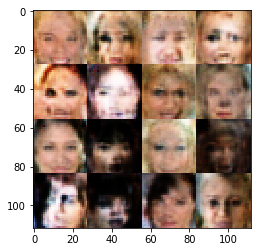

Epoch 1/2... Discriminator Loss: 0.4440... Generator Loss: 2.3755
Epoch 1/2... Discriminator Loss: 1.7889... Generator Loss: 0.2282
Epoch 1/2... Discriminator Loss: 1.5136... Generator Loss: 0.3935
Epoch 1/2... Discriminator Loss: 1.1277... Generator Loss: 0.8488
Epoch 1/2... Discriminator Loss: 1.3898... Generator Loss: 0.7979
Epoch 1/2... Discriminator Loss: 0.9540... Generator Loss: 2.7500
Epoch 1/2... Discriminator Loss: 1.3541... Generator Loss: 0.4658
Epoch 1/2... Discriminator Loss: 1.3588... Generator Loss: 0.5610
Epoch 1/2... Discriminator Loss: 1.4835... Generator Loss: 0.4311
Epoch 1/2... Discriminator Loss: 1.1721... Generator Loss: 0.9326


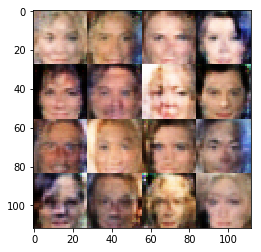

Epoch 1/2... Discriminator Loss: 0.9709... Generator Loss: 0.9296
Epoch 1/2... Discriminator Loss: 1.2187... Generator Loss: 0.9253
Epoch 1/2... Discriminator Loss: 1.1435... Generator Loss: 0.7320
Epoch 1/2... Discriminator Loss: 1.3503... Generator Loss: 0.8439
Epoch 1/2... Discriminator Loss: 1.3002... Generator Loss: 0.8655
Epoch 1/2... Discriminator Loss: 1.4336... Generator Loss: 0.9206
Epoch 1/2... Discriminator Loss: 1.4520... Generator Loss: 0.4446
Epoch 1/2... Discriminator Loss: 1.4306... Generator Loss: 0.3759
Epoch 1/2... Discriminator Loss: 1.3956... Generator Loss: 0.5066
Epoch 1/2... Discriminator Loss: 0.9618... Generator Loss: 1.4124


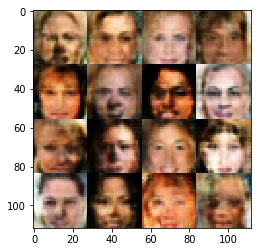

Epoch 1/2... Discriminator Loss: 1.1365... Generator Loss: 0.7383
Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 0.6279
Epoch 1/2... Discriminator Loss: 0.6552... Generator Loss: 1.5152
Epoch 1/2... Discriminator Loss: 1.5635... Generator Loss: 0.3299
Epoch 1/2... Discriminator Loss: 1.4044... Generator Loss: 0.4801
Epoch 1/2... Discriminator Loss: 0.7788... Generator Loss: 1.4949
Epoch 1/2... Discriminator Loss: 1.2416... Generator Loss: 1.0190
Epoch 1/2... Discriminator Loss: 1.3905... Generator Loss: 0.5012
Epoch 1/2... Discriminator Loss: 1.4029... Generator Loss: 0.6671
Epoch 1/2... Discriminator Loss: 1.0856... Generator Loss: 1.0921


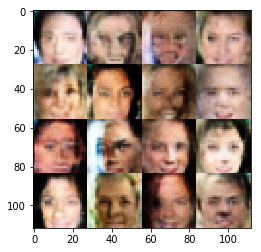

Epoch 1/2... Discriminator Loss: 1.2098... Generator Loss: 0.6167
Epoch 1/2... Discriminator Loss: 0.6899... Generator Loss: 2.9578
Epoch 1/2... Discriminator Loss: 0.6526... Generator Loss: 2.6844
Epoch 1/2... Discriminator Loss: 1.5260... Generator Loss: 1.5265
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 0.7832
Epoch 1/2... Discriminator Loss: 1.1197... Generator Loss: 0.7363
Epoch 1/2... Discriminator Loss: 1.4826... Generator Loss: 0.5443
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 0.5796
Epoch 1/2... Discriminator Loss: 0.7718... Generator Loss: 1.7413
Epoch 1/2... Discriminator Loss: 1.7405... Generator Loss: 1.0030


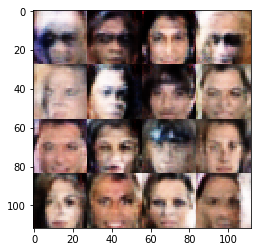

Epoch 1/2... Discriminator Loss: 1.1851... Generator Loss: 1.3943
Epoch 1/2... Discriminator Loss: 1.2752... Generator Loss: 0.5818
Epoch 1/2... Discriminator Loss: 1.0611... Generator Loss: 4.1551
Epoch 1/2... Discriminator Loss: 1.1450... Generator Loss: 0.7833
Epoch 1/2... Discriminator Loss: 1.0441... Generator Loss: 2.0183
Epoch 1/2... Discriminator Loss: 1.5105... Generator Loss: 0.3540
Epoch 1/2... Discriminator Loss: 1.6998... Generator Loss: 0.2996
Epoch 1/2... Discriminator Loss: 1.2878... Generator Loss: 0.5978
Epoch 1/2... Discriminator Loss: 1.5505... Generator Loss: 0.3510
Epoch 1/2... Discriminator Loss: 1.1655... Generator Loss: 2.0085


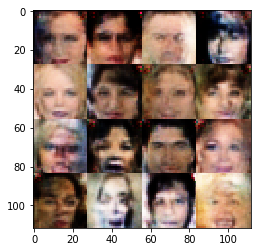

Epoch 1/2... Discriminator Loss: 1.3893... Generator Loss: 0.5388
Epoch 1/2... Discriminator Loss: 1.6758... Generator Loss: 1.2660
Epoch 1/2... Discriminator Loss: 1.1547... Generator Loss: 0.6145
Epoch 1/2... Discriminator Loss: 1.3181... Generator Loss: 0.4478
Epoch 1/2... Discriminator Loss: 1.9218... Generator Loss: 0.2120
Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 1.4569
Epoch 1/2... Discriminator Loss: 0.9805... Generator Loss: 0.8540
Epoch 1/2... Discriminator Loss: 1.4207... Generator Loss: 1.0624
Epoch 1/2... Discriminator Loss: 1.1029... Generator Loss: 0.9260
Epoch 1/2... Discriminator Loss: 1.6202... Generator Loss: 0.3413


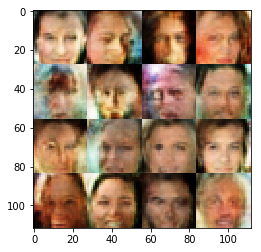

Epoch 1/2... Discriminator Loss: 1.3773... Generator Loss: 0.5752
Epoch 1/2... Discriminator Loss: 1.1880... Generator Loss: 0.6410
Epoch 1/2... Discriminator Loss: 1.2123... Generator Loss: 0.6224
Epoch 1/2... Discriminator Loss: 1.4585... Generator Loss: 2.5778
Epoch 1/2... Discriminator Loss: 1.2617... Generator Loss: 0.9613
Epoch 1/2... Discriminator Loss: 1.6739... Generator Loss: 0.3019
Epoch 1/2... Discriminator Loss: 1.3074... Generator Loss: 0.6281
Epoch 1/2... Discriminator Loss: 1.4048... Generator Loss: 1.0107
Epoch 1/2... Discriminator Loss: 1.8829... Generator Loss: 0.3377
Epoch 1/2... Discriminator Loss: 1.4594... Generator Loss: 0.4600


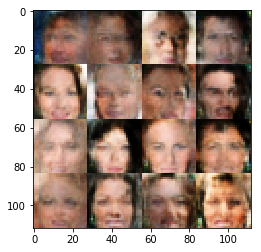

Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.5718
Epoch 1/2... Discriminator Loss: 1.3185... Generator Loss: 1.9701
Epoch 1/2... Discriminator Loss: 1.3875... Generator Loss: 0.4263
Epoch 1/2... Discriminator Loss: 1.6203... Generator Loss: 0.4381
Epoch 1/2... Discriminator Loss: 1.3787... Generator Loss: 0.5050
Epoch 1/2... Discriminator Loss: 1.2130... Generator Loss: 0.7649
Epoch 1/2... Discriminator Loss: 1.4051... Generator Loss: 0.6954
Epoch 1/2... Discriminator Loss: 1.9994... Generator Loss: 0.2173
Epoch 1/2... Discriminator Loss: 1.9533... Generator Loss: 0.2026
Epoch 1/2... Discriminator Loss: 1.2646... Generator Loss: 1.0863


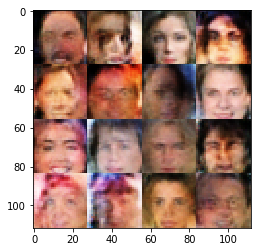

Epoch 1/2... Discriminator Loss: 1.6762... Generator Loss: 0.2894
Epoch 1/2... Discriminator Loss: 0.7978... Generator Loss: 2.4824
Epoch 1/2... Discriminator Loss: 1.6024... Generator Loss: 0.6162
Epoch 1/2... Discriminator Loss: 1.6376... Generator Loss: 0.4341
Epoch 1/2... Discriminator Loss: 1.2636... Generator Loss: 0.5716
Epoch 1/2... Discriminator Loss: 1.5182... Generator Loss: 0.4537
Epoch 1/2... Discriminator Loss: 1.5724... Generator Loss: 0.3861
Epoch 1/2... Discriminator Loss: 1.5394... Generator Loss: 0.6281
Epoch 1/2... Discriminator Loss: 1.5927... Generator Loss: 0.4337
Epoch 1/2... Discriminator Loss: 1.6538... Generator Loss: 0.3182


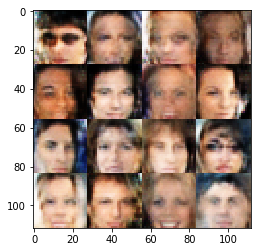

Epoch 1/2... Discriminator Loss: 1.0868... Generator Loss: 1.3384
Epoch 1/2... Discriminator Loss: 1.3242... Generator Loss: 0.5014
Epoch 1/2... Discriminator Loss: 1.5838... Generator Loss: 0.3349
Epoch 1/2... Discriminator Loss: 1.5523... Generator Loss: 0.3807
Epoch 1/2... Discriminator Loss: 1.0308... Generator Loss: 0.7807
Epoch 1/2... Discriminator Loss: 1.4627... Generator Loss: 0.7632
Epoch 1/2... Discriminator Loss: 1.6929... Generator Loss: 0.2839
Epoch 1/2... Discriminator Loss: 1.3090... Generator Loss: 0.5823
Epoch 1/2... Discriminator Loss: 1.3211... Generator Loss: 0.8441
Epoch 1/2... Discriminator Loss: 1.3895... Generator Loss: 0.8469


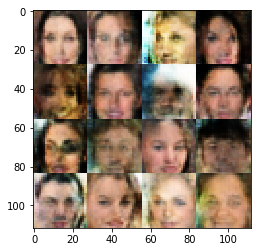

Epoch 1/2... Discriminator Loss: 1.4704... Generator Loss: 0.9981
Epoch 1/2... Discriminator Loss: 1.5085... Generator Loss: 0.5242
Epoch 1/2... Discriminator Loss: 1.1217... Generator Loss: 1.3671
Epoch 1/2... Discriminator Loss: 1.5085... Generator Loss: 0.9262
Epoch 1/2... Discriminator Loss: 1.6265... Generator Loss: 0.3814
Epoch 1/2... Discriminator Loss: 1.5582... Generator Loss: 0.3421
Epoch 1/2... Discriminator Loss: 1.0499... Generator Loss: 1.9240
Epoch 1/2... Discriminator Loss: 1.4620... Generator Loss: 0.4498
Epoch 1/2... Discriminator Loss: 1.4423... Generator Loss: 0.6074
Epoch 1/2... Discriminator Loss: 1.4268... Generator Loss: 0.8857


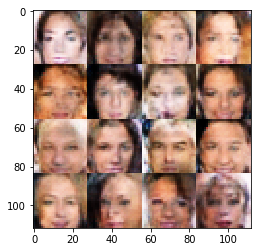

Epoch 1/2... Discriminator Loss: 0.8660... Generator Loss: 0.9514
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 0.4575
Epoch 1/2... Discriminator Loss: 1.5635... Generator Loss: 0.4886
Epoch 1/2... Discriminator Loss: 1.6660... Generator Loss: 0.3199
Epoch 1/2... Discriminator Loss: 1.2983... Generator Loss: 0.6283
Epoch 1/2... Discriminator Loss: 1.4224... Generator Loss: 0.5420
Epoch 1/2... Discriminator Loss: 1.1579... Generator Loss: 0.9716
Epoch 1/2... Discriminator Loss: 1.5009... Generator Loss: 0.5044
Epoch 1/2... Discriminator Loss: 0.9772... Generator Loss: 1.2283
Epoch 1/2... Discriminator Loss: 1.5031... Generator Loss: 0.5366


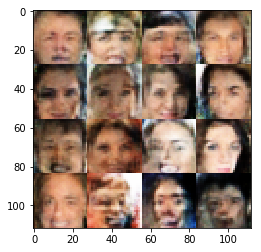

Epoch 1/2... Discriminator Loss: 1.4968... Generator Loss: 0.6916
Epoch 1/2... Discriminator Loss: 1.3480... Generator Loss: 0.6844
Epoch 1/2... Discriminator Loss: 1.3005... Generator Loss: 0.6791
Epoch 1/2... Discriminator Loss: 1.5801... Generator Loss: 0.4750
Epoch 1/2... Discriminator Loss: 1.5872... Generator Loss: 0.3511
Epoch 1/2... Discriminator Loss: 1.3425... Generator Loss: 0.5166
Epoch 1/2... Discriminator Loss: 1.5906... Generator Loss: 0.3328
Epoch 1/2... Discriminator Loss: 1.2500... Generator Loss: 0.5482
Epoch 1/2... Discriminator Loss: 1.4639... Generator Loss: 0.4722
Epoch 1/2... Discriminator Loss: 1.7180... Generator Loss: 0.3106


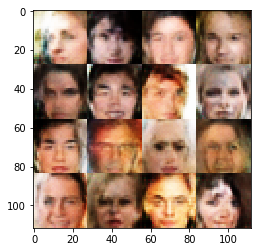

Epoch 1/2... Discriminator Loss: 1.7620... Generator Loss: 0.3212
Epoch 1/2... Discriminator Loss: 1.5488... Generator Loss: 0.3711
Epoch 1/2... Discriminator Loss: 1.6591... Generator Loss: 0.3538
Epoch 1/2... Discriminator Loss: 1.4521... Generator Loss: 0.4279
Epoch 1/2... Discriminator Loss: 1.4996... Generator Loss: 0.4597
Epoch 1/2... Discriminator Loss: 1.6011... Generator Loss: 0.3342
Epoch 1/2... Discriminator Loss: 1.1238... Generator Loss: 0.7578
Epoch 1/2... Discriminator Loss: 1.5578... Generator Loss: 0.3288
Epoch 1/2... Discriminator Loss: 1.9311... Generator Loss: 0.2112
Epoch 1/2... Discriminator Loss: 1.7676... Generator Loss: 0.3973


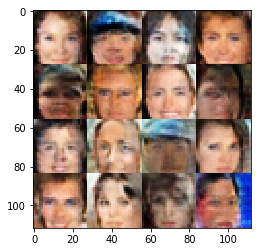

Epoch 1/2... Discriminator Loss: 1.4584... Generator Loss: 0.4478
Epoch 1/2... Discriminator Loss: 1.4561... Generator Loss: 0.5855
Epoch 1/2... Discriminator Loss: 1.4646... Generator Loss: 0.4662
Epoch 1/2... Discriminator Loss: 1.4719... Generator Loss: 0.5123
Epoch 1/2... Discriminator Loss: 1.7004... Generator Loss: 0.5960
Epoch 1/2... Discriminator Loss: 1.4761... Generator Loss: 0.6446
Epoch 1/2... Discriminator Loss: 1.5559... Generator Loss: 0.4714
Epoch 1/2... Discriminator Loss: 1.1974... Generator Loss: 0.8380
Epoch 1/2... Discriminator Loss: 1.4950... Generator Loss: 0.5625
Epoch 1/2... Discriminator Loss: 1.3537... Generator Loss: 0.6549


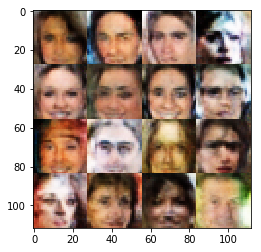

Epoch 1/2... Discriminator Loss: 1.7187... Generator Loss: 0.3417
Epoch 1/2... Discriminator Loss: 1.3985... Generator Loss: 0.4775
Epoch 1/2... Discriminator Loss: 1.4674... Generator Loss: 0.4786
Epoch 1/2... Discriminator Loss: 1.5199... Generator Loss: 0.4198
Epoch 1/2... Discriminator Loss: 2.0259... Generator Loss: 0.1874
Epoch 1/2... Discriminator Loss: 1.1437... Generator Loss: 1.0340
Epoch 1/2... Discriminator Loss: 1.2741... Generator Loss: 0.7602
Epoch 1/2... Discriminator Loss: 1.4680... Generator Loss: 0.5275
Epoch 1/2... Discriminator Loss: 1.3184... Generator Loss: 0.5710
Epoch 1/2... Discriminator Loss: 1.5995... Generator Loss: 0.4414


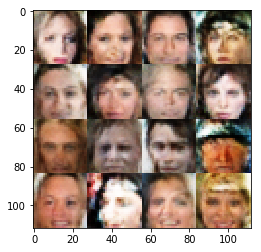

Epoch 1/2... Discriminator Loss: 1.6244... Generator Loss: 0.3275
Epoch 1/2... Discriminator Loss: 1.2168... Generator Loss: 0.6654
Epoch 1/2... Discriminator Loss: 1.4214... Generator Loss: 0.5815
Epoch 1/2... Discriminator Loss: 1.1199... Generator Loss: 0.8522
Epoch 1/2... Discriminator Loss: 1.5677... Generator Loss: 0.5063
Epoch 1/2... Discriminator Loss: 1.4860... Generator Loss: 0.4338
Epoch 1/2... Discriminator Loss: 1.5993... Generator Loss: 0.5157
Epoch 1/2... Discriminator Loss: 1.4086... Generator Loss: 0.5315
Epoch 1/2... Discriminator Loss: 1.5183... Generator Loss: 0.3970
Epoch 1/2... Discriminator Loss: 1.2755... Generator Loss: 0.5615


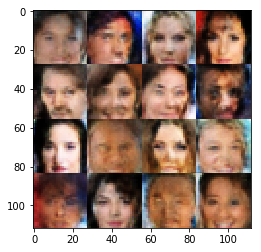

Epoch 1/2... Discriminator Loss: 1.7965... Generator Loss: 0.2536
Epoch 1/2... Discriminator Loss: 1.4734... Generator Loss: 0.4695
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.4930
Epoch 1/2... Discriminator Loss: 1.0659... Generator Loss: 1.4081
Epoch 1/2... Discriminator Loss: 1.7279... Generator Loss: 0.4309
Epoch 1/2... Discriminator Loss: 1.2558... Generator Loss: 0.6230
Epoch 1/2... Discriminator Loss: 1.5967... Generator Loss: 0.4913
Epoch 1/2... Discriminator Loss: 1.5115... Generator Loss: 0.3563
Epoch 1/2... Discriminator Loss: 1.3695... Generator Loss: 0.7326
Epoch 1/2... Discriminator Loss: 1.7235... Generator Loss: 0.6178


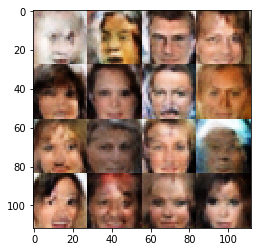

Epoch 1/2... Discriminator Loss: 1.4037... Generator Loss: 0.5121
Epoch 1/2... Discriminator Loss: 1.5052... Generator Loss: 0.4979
Epoch 1/2... Discriminator Loss: 1.5310... Generator Loss: 0.5465
Epoch 1/2... Discriminator Loss: 1.5846... Generator Loss: 0.4332
Epoch 1/2... Discriminator Loss: 1.5319... Generator Loss: 0.4863
Epoch 1/2... Discriminator Loss: 1.0961... Generator Loss: 1.1307
Epoch 1/2... Discriminator Loss: 1.2100... Generator Loss: 1.0667
Epoch 1/2... Discriminator Loss: 1.5106... Generator Loss: 0.4464
Epoch 1/2... Discriminator Loss: 1.6095... Generator Loss: 0.3790
Epoch 1/2... Discriminator Loss: 1.6759... Generator Loss: 0.5299


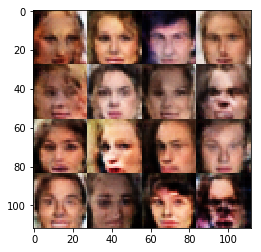

Epoch 1/2... Discriminator Loss: 1.3709... Generator Loss: 0.5095
Epoch 1/2... Discriminator Loss: 1.4518... Generator Loss: 0.6948
Epoch 1/2... Discriminator Loss: 1.4527... Generator Loss: 0.3997
Epoch 1/2... Discriminator Loss: 1.2394... Generator Loss: 0.6314
Epoch 1/2... Discriminator Loss: 1.4818... Generator Loss: 0.9274
Epoch 1/2... Discriminator Loss: 1.3757... Generator Loss: 0.5722
Epoch 1/2... Discriminator Loss: 1.3833... Generator Loss: 0.8002
Epoch 1/2... Discriminator Loss: 1.6328... Generator Loss: 0.5333
Epoch 1/2... Discriminator Loss: 1.6732... Generator Loss: 0.2737
Epoch 1/2... Discriminator Loss: 1.7215... Generator Loss: 0.5185


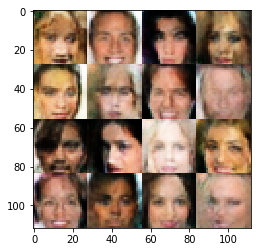

Epoch 1/2... Discriminator Loss: 1.5458... Generator Loss: 0.3877
Epoch 1/2... Discriminator Loss: 1.5040... Generator Loss: 0.3755
Epoch 1/2... Discriminator Loss: 1.6533... Generator Loss: 0.5479
Epoch 1/2... Discriminator Loss: 1.5668... Generator Loss: 0.6481
Epoch 1/2... Discriminator Loss: 1.6826... Generator Loss: 0.4548
Epoch 1/2... Discriminator Loss: 1.3796... Generator Loss: 0.4349
Epoch 2/2... Discriminator Loss: 1.3224... Generator Loss: 0.7365
Epoch 2/2... Discriminator Loss: 1.5291... Generator Loss: 0.4718
Epoch 2/2... Discriminator Loss: 1.5342... Generator Loss: 0.5303
Epoch 2/2... Discriminator Loss: 1.1261... Generator Loss: 0.7180


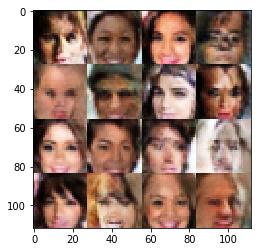

Epoch 2/2... Discriminator Loss: 1.5893... Generator Loss: 0.6491
Epoch 2/2... Discriminator Loss: 1.7884... Generator Loss: 0.3168
Epoch 2/2... Discriminator Loss: 1.8706... Generator Loss: 0.2820
Epoch 2/2... Discriminator Loss: 1.4946... Generator Loss: 0.5529
Epoch 2/2... Discriminator Loss: 1.3549... Generator Loss: 0.5045
Epoch 2/2... Discriminator Loss: 0.9313... Generator Loss: 1.6626
Epoch 2/2... Discriminator Loss: 1.7224... Generator Loss: 0.2981
Epoch 2/2... Discriminator Loss: 1.5362... Generator Loss: 0.3862
Epoch 2/2... Discriminator Loss: 1.3143... Generator Loss: 0.7400
Epoch 2/2... Discriminator Loss: 1.9384... Generator Loss: 0.2540


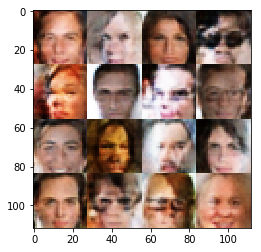

Epoch 2/2... Discriminator Loss: 1.5228... Generator Loss: 0.4576
Epoch 2/2... Discriminator Loss: 1.3608... Generator Loss: 0.9861
Epoch 2/2... Discriminator Loss: 1.7366... Generator Loss: 0.3762
Epoch 2/2... Discriminator Loss: 1.5937... Generator Loss: 0.5055
Epoch 2/2... Discriminator Loss: 1.4912... Generator Loss: 0.4853
Epoch 2/2... Discriminator Loss: 1.5148... Generator Loss: 0.5003
Epoch 2/2... Discriminator Loss: 1.6647... Generator Loss: 0.6840
Epoch 2/2... Discriminator Loss: 1.7575... Generator Loss: 0.4268
Epoch 2/2... Discriminator Loss: 1.7437... Generator Loss: 0.3214
Epoch 2/2... Discriminator Loss: 1.4551... Generator Loss: 0.4957


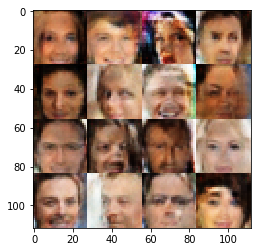

Epoch 2/2... Discriminator Loss: 1.5870... Generator Loss: 0.3623
Epoch 2/2... Discriminator Loss: 1.5066... Generator Loss: 0.4823
Epoch 2/2... Discriminator Loss: 1.4719... Generator Loss: 0.4801
Epoch 2/2... Discriminator Loss: 1.4841... Generator Loss: 0.4796
Epoch 2/2... Discriminator Loss: 1.5090... Generator Loss: 0.4723
Epoch 2/2... Discriminator Loss: 1.3505... Generator Loss: 0.5440
Epoch 2/2... Discriminator Loss: 1.5379... Generator Loss: 0.4794
Epoch 2/2... Discriminator Loss: 1.5831... Generator Loss: 0.4435
Epoch 2/2... Discriminator Loss: 1.9784... Generator Loss: 0.2394
Epoch 2/2... Discriminator Loss: 1.5173... Generator Loss: 0.3722


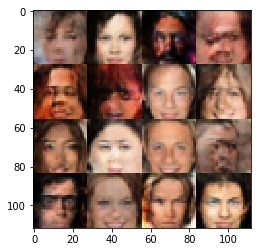

Epoch 2/2... Discriminator Loss: 1.6472... Generator Loss: 0.3696
Epoch 2/2... Discriminator Loss: 1.4522... Generator Loss: 0.4615
Epoch 2/2... Discriminator Loss: 1.6977... Generator Loss: 0.9516
Epoch 2/2... Discriminator Loss: 1.4116... Generator Loss: 0.5277
Epoch 2/2... Discriminator Loss: 1.6412... Generator Loss: 0.3985
Epoch 2/2... Discriminator Loss: 1.5591... Generator Loss: 0.3905
Epoch 2/2... Discriminator Loss: 1.5092... Generator Loss: 0.3989
Epoch 2/2... Discriminator Loss: 1.5783... Generator Loss: 0.4683
Epoch 2/2... Discriminator Loss: 1.4928... Generator Loss: 0.4920
Epoch 2/2... Discriminator Loss: 1.5372... Generator Loss: 0.4109


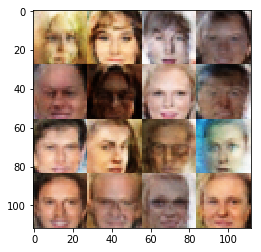

Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 0.6382
Epoch 2/2... Discriminator Loss: 1.4791... Generator Loss: 0.5476
Epoch 2/2... Discriminator Loss: 1.2309... Generator Loss: 0.7430
Epoch 2/2... Discriminator Loss: 1.5779... Generator Loss: 0.3470
Epoch 2/2... Discriminator Loss: 1.3753... Generator Loss: 0.6524
Epoch 2/2... Discriminator Loss: 1.4631... Generator Loss: 0.4386
Epoch 2/2... Discriminator Loss: 1.7333... Generator Loss: 0.2869
Epoch 2/2... Discriminator Loss: 1.5118... Generator Loss: 0.4977
Epoch 2/2... Discriminator Loss: 1.5713... Generator Loss: 0.5550
Epoch 2/2... Discriminator Loss: 1.4732... Generator Loss: 0.4400


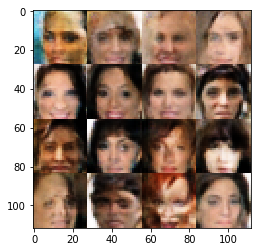

Epoch 2/2... Discriminator Loss: 1.6249... Generator Loss: 0.3781
Epoch 2/2... Discriminator Loss: 1.6301... Generator Loss: 0.3609
Epoch 2/2... Discriminator Loss: 1.7311... Generator Loss: 0.4729
Epoch 2/2... Discriminator Loss: 1.7389... Generator Loss: 0.3316
Epoch 2/2... Discriminator Loss: 1.3603... Generator Loss: 0.5598
Epoch 2/2... Discriminator Loss: 1.7351... Generator Loss: 0.3201
Epoch 2/2... Discriminator Loss: 1.2613... Generator Loss: 0.7286
Epoch 2/2... Discriminator Loss: 1.5887... Generator Loss: 0.4241
Epoch 2/2... Discriminator Loss: 1.4575... Generator Loss: 0.6128
Epoch 2/2... Discriminator Loss: 1.4277... Generator Loss: 0.6692


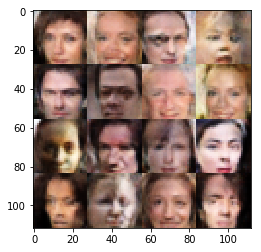

Epoch 2/2... Discriminator Loss: 1.5666... Generator Loss: 0.4527
Epoch 2/2... Discriminator Loss: 2.0211... Generator Loss: 0.2045
Epoch 2/2... Discriminator Loss: 1.7543... Generator Loss: 0.2672
Epoch 2/2... Discriminator Loss: 1.3876... Generator Loss: 0.8077
Epoch 2/2... Discriminator Loss: 1.3988... Generator Loss: 0.5139
Epoch 2/2... Discriminator Loss: 1.3943... Generator Loss: 0.6929
Epoch 2/2... Discriminator Loss: 1.8772... Generator Loss: 0.2972
Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 0.6499
Epoch 2/2... Discriminator Loss: 1.5109... Generator Loss: 0.4487
Epoch 2/2... Discriminator Loss: 1.4471... Generator Loss: 0.5200


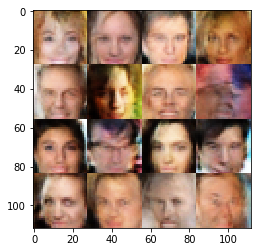

Epoch 2/2... Discriminator Loss: 1.5733... Generator Loss: 0.6380
Epoch 2/2... Discriminator Loss: 1.5790... Generator Loss: 0.4186
Epoch 2/2... Discriminator Loss: 1.4166... Generator Loss: 0.6775
Epoch 2/2... Discriminator Loss: 1.7995... Generator Loss: 0.2669
Epoch 2/2... Discriminator Loss: 1.2744... Generator Loss: 0.5395
Epoch 2/2... Discriminator Loss: 1.3913... Generator Loss: 0.5483
Epoch 2/2... Discriminator Loss: 1.2502... Generator Loss: 0.7149
Epoch 2/2... Discriminator Loss: 1.6588... Generator Loss: 0.3543
Epoch 2/2... Discriminator Loss: 1.4574... Generator Loss: 0.5538
Epoch 2/2... Discriminator Loss: 1.2388... Generator Loss: 0.8509


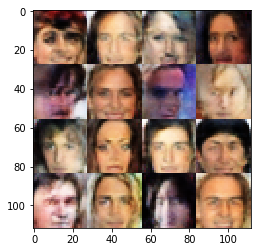

Epoch 2/2... Discriminator Loss: 1.2816... Generator Loss: 0.5907
Epoch 2/2... Discriminator Loss: 1.4591... Generator Loss: 0.6924
Epoch 2/2... Discriminator Loss: 1.3937... Generator Loss: 0.5421
Epoch 2/2... Discriminator Loss: 1.5951... Generator Loss: 0.4980
Epoch 2/2... Discriminator Loss: 1.9307... Generator Loss: 0.2167
Epoch 2/2... Discriminator Loss: 1.7727... Generator Loss: 0.3180
Epoch 2/2... Discriminator Loss: 1.5867... Generator Loss: 0.5702
Epoch 2/2... Discriminator Loss: 1.7339... Generator Loss: 0.5797
Epoch 2/2... Discriminator Loss: 1.7359... Generator Loss: 0.4902
Epoch 2/2... Discriminator Loss: 1.5566... Generator Loss: 0.5037


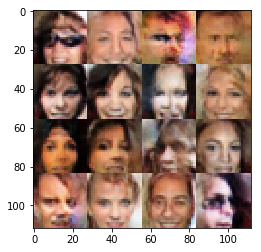

Epoch 2/2... Discriminator Loss: 1.5214... Generator Loss: 0.5318
Epoch 2/2... Discriminator Loss: 1.6643... Generator Loss: 0.4196
Epoch 2/2... Discriminator Loss: 1.5271... Generator Loss: 0.4119
Epoch 2/2... Discriminator Loss: 1.5472... Generator Loss: 0.5372
Epoch 2/2... Discriminator Loss: 1.6087... Generator Loss: 0.4278
Epoch 2/2... Discriminator Loss: 1.0786... Generator Loss: 0.9049
Epoch 2/2... Discriminator Loss: 1.5588... Generator Loss: 0.5209
Epoch 2/2... Discriminator Loss: 1.3927... Generator Loss: 0.7012
Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.7130
Epoch 2/2... Discriminator Loss: 1.4886... Generator Loss: 0.5180


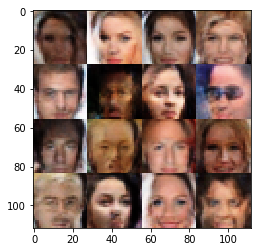

Epoch 2/2... Discriminator Loss: 1.4759... Generator Loss: 0.4852
Epoch 2/2... Discriminator Loss: 1.6597... Generator Loss: 0.4516
Epoch 2/2... Discriminator Loss: 1.3477... Generator Loss: 0.6669
Epoch 2/2... Discriminator Loss: 1.5107... Generator Loss: 0.4314
Epoch 2/2... Discriminator Loss: 1.5733... Generator Loss: 0.5117
Epoch 2/2... Discriminator Loss: 1.6715... Generator Loss: 0.4578
Epoch 2/2... Discriminator Loss: 1.6012... Generator Loss: 0.3697
Epoch 2/2... Discriminator Loss: 1.5624... Generator Loss: 0.4498
Epoch 2/2... Discriminator Loss: 1.3122... Generator Loss: 0.6089
Epoch 2/2... Discriminator Loss: 1.4433... Generator Loss: 0.6818


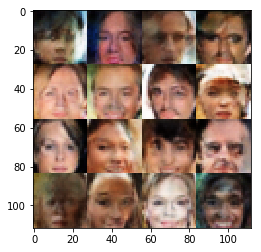

Epoch 2/2... Discriminator Loss: 1.3179... Generator Loss: 0.6830
Epoch 2/2... Discriminator Loss: 1.5013... Generator Loss: 0.5927
Epoch 2/2... Discriminator Loss: 1.7018... Generator Loss: 0.4862
Epoch 2/2... Discriminator Loss: 1.4297... Generator Loss: 0.5647
Epoch 2/2... Discriminator Loss: 1.4339... Generator Loss: 0.6076
Epoch 2/2... Discriminator Loss: 1.6009... Generator Loss: 0.3579
Epoch 2/2... Discriminator Loss: 1.3953... Generator Loss: 0.5208
Epoch 2/2... Discriminator Loss: 1.5608... Generator Loss: 0.4123
Epoch 2/2... Discriminator Loss: 1.5918... Generator Loss: 0.4217
Epoch 2/2... Discriminator Loss: 1.5231... Generator Loss: 0.4310


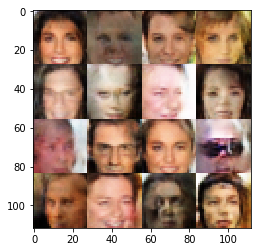

Epoch 2/2... Discriminator Loss: 1.4208... Generator Loss: 0.5616
Epoch 2/2... Discriminator Loss: 1.6941... Generator Loss: 0.3611
Epoch 2/2... Discriminator Loss: 1.5436... Generator Loss: 0.3870
Epoch 2/2... Discriminator Loss: 1.7068... Generator Loss: 0.3271
Epoch 2/2... Discriminator Loss: 1.4819... Generator Loss: 0.7191
Epoch 2/2... Discriminator Loss: 1.2335... Generator Loss: 0.7519
Epoch 2/2... Discriminator Loss: 1.6352... Generator Loss: 0.4487
Epoch 2/2... Discriminator Loss: 1.5140... Generator Loss: 0.5674
Epoch 2/2... Discriminator Loss: 1.1709... Generator Loss: 1.3771
Epoch 2/2... Discriminator Loss: 1.4988... Generator Loss: 0.5443


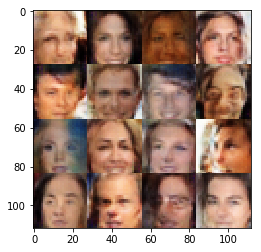

Epoch 2/2... Discriminator Loss: 1.4357... Generator Loss: 0.4776
Epoch 2/2... Discriminator Loss: 1.4395... Generator Loss: 0.6410
Epoch 2/2... Discriminator Loss: 1.6292... Generator Loss: 0.5600
Epoch 2/2... Discriminator Loss: 1.6917... Generator Loss: 0.4130
Epoch 2/2... Discriminator Loss: 1.5486... Generator Loss: 0.5138
Epoch 2/2... Discriminator Loss: 1.4780... Generator Loss: 0.4727
Epoch 2/2... Discriminator Loss: 1.6375... Generator Loss: 0.4865
Epoch 2/2... Discriminator Loss: 1.5637... Generator Loss: 0.6023
Epoch 2/2... Discriminator Loss: 1.5018... Generator Loss: 0.6605
Epoch 2/2... Discriminator Loss: 1.4227... Generator Loss: 0.4380


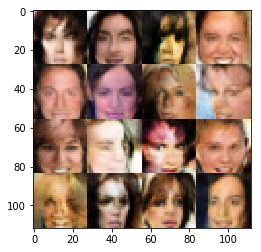

Epoch 2/2... Discriminator Loss: 1.7310... Generator Loss: 0.3561
Epoch 2/2... Discriminator Loss: 1.6370... Generator Loss: 0.4568
Epoch 2/2... Discriminator Loss: 1.3281... Generator Loss: 0.4836
Epoch 2/2... Discriminator Loss: 1.5213... Generator Loss: 0.4121
Epoch 2/2... Discriminator Loss: 1.6483... Generator Loss: 0.4985
Epoch 2/2... Discriminator Loss: 1.5689... Generator Loss: 0.4676
Epoch 2/2... Discriminator Loss: 1.4079... Generator Loss: 0.5623
Epoch 2/2... Discriminator Loss: 1.9085... Generator Loss: 0.3495
Epoch 2/2... Discriminator Loss: 1.7416... Generator Loss: 0.2678
Epoch 2/2... Discriminator Loss: 1.4303... Generator Loss: 0.4969


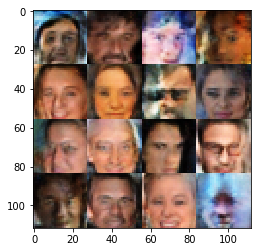

Epoch 2/2... Discriminator Loss: 1.5760... Generator Loss: 0.5430
Epoch 2/2... Discriminator Loss: 1.6312... Generator Loss: 0.4167
Epoch 2/2... Discriminator Loss: 1.4383... Generator Loss: 0.4157
Epoch 2/2... Discriminator Loss: 1.5681... Generator Loss: 0.4273
Epoch 2/2... Discriminator Loss: 1.5746... Generator Loss: 0.4074
Epoch 2/2... Discriminator Loss: 1.5939... Generator Loss: 0.4801
Epoch 2/2... Discriminator Loss: 1.5249... Generator Loss: 0.4833
Epoch 2/2... Discriminator Loss: 1.5204... Generator Loss: 0.4691
Epoch 2/2... Discriminator Loss: 1.8929... Generator Loss: 0.2910
Epoch 2/2... Discriminator Loss: 1.4185... Generator Loss: 0.5110


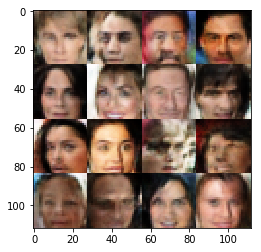

Epoch 2/2... Discriminator Loss: 1.7488... Generator Loss: 0.2966
Epoch 2/2... Discriminator Loss: 1.6465... Generator Loss: 0.3943
Epoch 2/2... Discriminator Loss: 1.5359... Generator Loss: 0.5139
Epoch 2/2... Discriminator Loss: 1.7074... Generator Loss: 0.4677
Epoch 2/2... Discriminator Loss: 1.5557... Generator Loss: 0.5121
Epoch 2/2... Discriminator Loss: 1.4885... Generator Loss: 0.4763
Epoch 2/2... Discriminator Loss: 1.9074... Generator Loss: 0.2480
Epoch 2/2... Discriminator Loss: 1.9275... Generator Loss: 0.5474
Epoch 2/2... Discriminator Loss: 1.3100... Generator Loss: 0.6846
Epoch 2/2... Discriminator Loss: 1.3126... Generator Loss: 0.5947


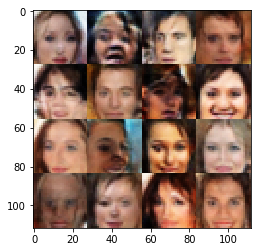

Epoch 2/2... Discriminator Loss: 1.8211... Generator Loss: 0.2481
Epoch 2/2... Discriminator Loss: 1.2529... Generator Loss: 0.8084
Epoch 2/2... Discriminator Loss: 1.7214... Generator Loss: 0.5892
Epoch 2/2... Discriminator Loss: 1.3826... Generator Loss: 0.5144
Epoch 2/2... Discriminator Loss: 1.7402... Generator Loss: 0.3342
Epoch 2/2... Discriminator Loss: 1.6121... Generator Loss: 0.3844
Epoch 2/2... Discriminator Loss: 1.7166... Generator Loss: 0.3926
Epoch 2/2... Discriminator Loss: 1.5893... Generator Loss: 0.3719
Epoch 2/2... Discriminator Loss: 1.2653... Generator Loss: 0.6553
Epoch 2/2... Discriminator Loss: 1.6944... Generator Loss: 0.2957


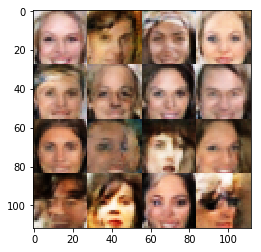

Epoch 2/2... Discriminator Loss: 1.5464... Generator Loss: 0.3585
Epoch 2/2... Discriminator Loss: 1.6555... Generator Loss: 0.3316
Epoch 2/2... Discriminator Loss: 1.6215... Generator Loss: 0.4529
Epoch 2/2... Discriminator Loss: 1.6671... Generator Loss: 0.4495
Epoch 2/2... Discriminator Loss: 1.6668... Generator Loss: 0.4343
Epoch 2/2... Discriminator Loss: 1.4511... Generator Loss: 0.4497
Epoch 2/2... Discriminator Loss: 1.6032... Generator Loss: 0.4070
Epoch 2/2... Discriminator Loss: 1.5047... Generator Loss: 0.5035
Epoch 2/2... Discriminator Loss: 1.3752... Generator Loss: 0.6487
Epoch 2/2... Discriminator Loss: 1.6297... Generator Loss: 0.3431


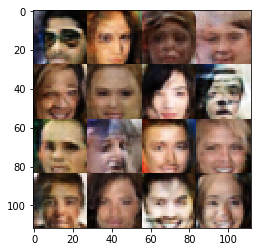

Epoch 2/2... Discriminator Loss: 1.5180... Generator Loss: 0.5728
Epoch 2/2... Discriminator Loss: 1.4439... Generator Loss: 0.5771
Epoch 2/2... Discriminator Loss: 1.6802... Generator Loss: 0.3466
Epoch 2/2... Discriminator Loss: 1.4396... Generator Loss: 0.4751
Epoch 2/2... Discriminator Loss: 1.4080... Generator Loss: 0.5332
Epoch 2/2... Discriminator Loss: 1.3015... Generator Loss: 0.5923
Epoch 2/2... Discriminator Loss: 1.5873... Generator Loss: 0.5192
Epoch 2/2... Discriminator Loss: 1.0294... Generator Loss: 1.1967
Epoch 2/2... Discriminator Loss: 1.6507... Generator Loss: 0.3345
Epoch 2/2... Discriminator Loss: 1.1773... Generator Loss: 0.6241


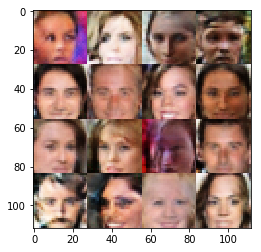

Epoch 2/2... Discriminator Loss: 1.3777... Generator Loss: 0.6143
Epoch 2/2... Discriminator Loss: 1.5491... Generator Loss: 0.5369
Epoch 2/2... Discriminator Loss: 1.5916... Generator Loss: 0.3996
Epoch 2/2... Discriminator Loss: 1.5497... Generator Loss: 0.3705
Epoch 2/2... Discriminator Loss: 1.9310... Generator Loss: 0.3766
Epoch 2/2... Discriminator Loss: 1.7959... Generator Loss: 0.2743
Epoch 2/2... Discriminator Loss: 1.3678... Generator Loss: 0.4951
Epoch 2/2... Discriminator Loss: 1.6678... Generator Loss: 0.3103
Epoch 2/2... Discriminator Loss: 1.7053... Generator Loss: 0.3738
Epoch 2/2... Discriminator Loss: 1.8496... Generator Loss: 0.2760


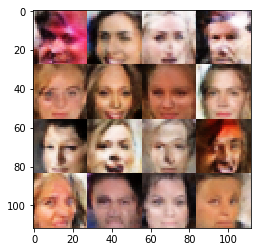

Epoch 2/2... Discriminator Loss: 1.4750... Generator Loss: 0.5057
Epoch 2/2... Discriminator Loss: 1.6269... Generator Loss: 0.4492
Epoch 2/2... Discriminator Loss: 1.3869... Generator Loss: 0.7642
Epoch 2/2... Discriminator Loss: 1.8049... Generator Loss: 0.3699
Epoch 2/2... Discriminator Loss: 1.6953... Generator Loss: 0.2963
Epoch 2/2... Discriminator Loss: 1.6016... Generator Loss: 0.3798
Epoch 2/2... Discriminator Loss: 1.3506... Generator Loss: 0.4643
Epoch 2/2... Discriminator Loss: 1.4650... Generator Loss: 0.4149
Epoch 2/2... Discriminator Loss: 1.4792... Generator Loss: 0.4787
Epoch 2/2... Discriminator Loss: 1.1813... Generator Loss: 0.9635


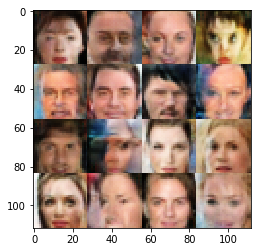

Epoch 2/2... Discriminator Loss: 1.6573... Generator Loss: 0.5384
Epoch 2/2... Discriminator Loss: 1.4512... Generator Loss: 0.5863
Epoch 2/2... Discriminator Loss: 1.7512... Generator Loss: 0.2761
Epoch 2/2... Discriminator Loss: 1.6852... Generator Loss: 0.3261
Epoch 2/2... Discriminator Loss: 1.5936... Generator Loss: 0.4555
Epoch 2/2... Discriminator Loss: 1.6286... Generator Loss: 0.3271
Epoch 2/2... Discriminator Loss: 1.7284... Generator Loss: 0.3692
Epoch 2/2... Discriminator Loss: 1.6038... Generator Loss: 0.3797
Epoch 2/2... Discriminator Loss: 1.5704... Generator Loss: 0.4199
Epoch 2/2... Discriminator Loss: 1.4808... Generator Loss: 0.4697


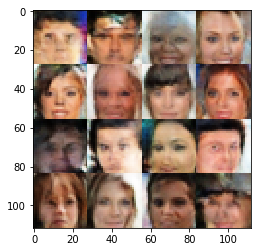

Epoch 2/2... Discriminator Loss: 1.4144... Generator Loss: 0.5025
Epoch 2/2... Discriminator Loss: 0.9532... Generator Loss: 1.0420
Epoch 2/2... Discriminator Loss: 1.7589... Generator Loss: 0.3586
Epoch 2/2... Discriminator Loss: 1.3983... Generator Loss: 0.5385
Epoch 2/2... Discriminator Loss: 1.7185... Generator Loss: 0.2609
Epoch 2/2... Discriminator Loss: 1.4498... Generator Loss: 0.4523
Epoch 2/2... Discriminator Loss: 1.7405... Generator Loss: 0.3270
Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 0.8524
Epoch 2/2... Discriminator Loss: 1.3991... Generator Loss: 0.4964
Epoch 2/2... Discriminator Loss: 1.4255... Generator Loss: 0.4848


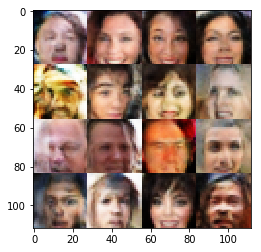

Epoch 2/2... Discriminator Loss: 1.5800... Generator Loss: 0.4869
Epoch 2/2... Discriminator Loss: 1.5884... Generator Loss: 0.3537
Epoch 2/2... Discriminator Loss: 1.5901... Generator Loss: 0.3170
Epoch 2/2... Discriminator Loss: 1.4289... Generator Loss: 0.4892
Epoch 2/2... Discriminator Loss: 1.5828... Generator Loss: 0.3504
Epoch 2/2... Discriminator Loss: 1.5951... Generator Loss: 0.4959
Epoch 2/2... Discriminator Loss: 1.6915... Generator Loss: 0.4281
Epoch 2/2... Discriminator Loss: 1.3890... Generator Loss: 0.5444
Epoch 2/2... Discriminator Loss: 1.6431... Generator Loss: 0.4673
Epoch 2/2... Discriminator Loss: 1.2348... Generator Loss: 0.6290


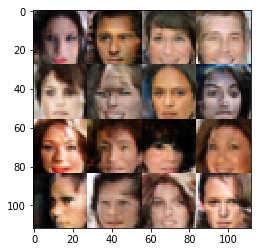

Epoch 2/2... Discriminator Loss: 1.5089... Generator Loss: 0.4727
Epoch 2/2... Discriminator Loss: 1.7079... Generator Loss: 0.3389
Epoch 2/2... Discriminator Loss: 1.5599... Generator Loss: 0.6072
Epoch 2/2... Discriminator Loss: 1.6862... Generator Loss: 0.3255
Epoch 2/2... Discriminator Loss: 1.6552... Generator Loss: 0.3956
Epoch 2/2... Discriminator Loss: 1.4712... Generator Loss: 0.4102
Epoch 2/2... Discriminator Loss: 1.7154... Generator Loss: 0.3067
Epoch 2/2... Discriminator Loss: 1.4317... Generator Loss: 0.6517
Epoch 2/2... Discriminator Loss: 1.3143... Generator Loss: 0.6493
Epoch 2/2... Discriminator Loss: 1.3126... Generator Loss: 0.6703


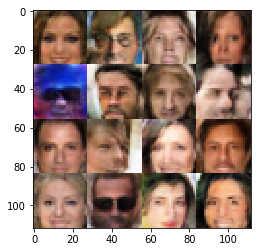

Epoch 2/2... Discriminator Loss: 1.7515... Generator Loss: 0.3830
Epoch 2/2... Discriminator Loss: 1.7212... Generator Loss: 0.2747
Epoch 2/2... Discriminator Loss: 1.4674... Generator Loss: 0.7431
Epoch 2/2... Discriminator Loss: 1.4151... Generator Loss: 0.5477
Epoch 2/2... Discriminator Loss: 1.6408... Generator Loss: 0.3896
Epoch 2/2... Discriminator Loss: 1.4512... Generator Loss: 0.6503
Epoch 2/2... Discriminator Loss: 1.4655... Generator Loss: 0.5135
Epoch 2/2... Discriminator Loss: 1.3299... Generator Loss: 0.7139
Epoch 2/2... Discriminator Loss: 1.6317... Generator Loss: 0.3472
Epoch 2/2... Discriminator Loss: 1.5855... Generator Loss: 0.3970


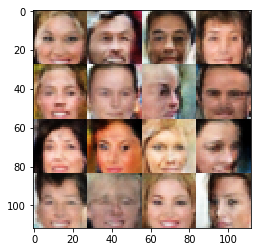

Epoch 2/2... Discriminator Loss: 1.6381... Generator Loss: 0.3125
Epoch 2/2... Discriminator Loss: 1.4943... Generator Loss: 0.5323
Epoch 2/2... Discriminator Loss: 1.7286... Generator Loss: 0.2870
Epoch 2/2... Discriminator Loss: 1.6955... Generator Loss: 0.4189
Epoch 2/2... Discriminator Loss: 1.2236... Generator Loss: 0.6313
Epoch 2/2... Discriminator Loss: 1.5785... Generator Loss: 0.3631
Epoch 2/2... Discriminator Loss: 1.5202... Generator Loss: 0.3954
Epoch 2/2... Discriminator Loss: 1.5299... Generator Loss: 0.3983
Epoch 2/2... Discriminator Loss: 1.7097... Generator Loss: 0.3712
Epoch 2/2... Discriminator Loss: 1.3777... Generator Loss: 0.4952


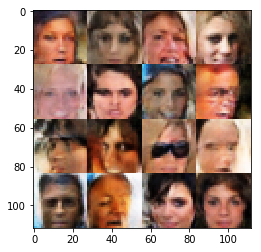

Epoch 2/2... Discriminator Loss: 1.3543... Generator Loss: 0.9022
Epoch 2/2... Discriminator Loss: 1.5036... Generator Loss: 0.5118
Epoch 2/2... Discriminator Loss: 1.4407... Generator Loss: 0.4936
Epoch 2/2... Discriminator Loss: 1.4334... Generator Loss: 0.4860
Epoch 2/2... Discriminator Loss: 2.0085... Generator Loss: 0.2219
Epoch 2/2... Discriminator Loss: 1.2838... Generator Loss: 0.5919
Epoch 2/2... Discriminator Loss: 1.5879... Generator Loss: 0.5961
Epoch 2/2... Discriminator Loss: 1.6067... Generator Loss: 0.3979
Epoch 2/2... Discriminator Loss: 1.7010... Generator Loss: 0.2721
Epoch 2/2... Discriminator Loss: 1.6397... Generator Loss: 0.4056


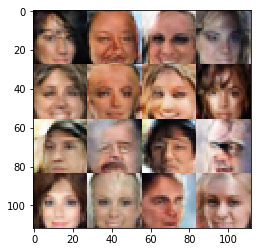

Epoch 2/2... Discriminator Loss: 1.4566... Generator Loss: 0.5654
Epoch 2/2... Discriminator Loss: 1.7221... Generator Loss: 0.4017
Epoch 2/2... Discriminator Loss: 1.8063... Generator Loss: 0.2695
Epoch 2/2... Discriminator Loss: 1.8965... Generator Loss: 0.2617
Epoch 2/2... Discriminator Loss: 1.4060... Generator Loss: 0.4981
Epoch 2/2... Discriminator Loss: 1.3442... Generator Loss: 0.5509
Epoch 2/2... Discriminator Loss: 1.4800... Generator Loss: 0.4160
Epoch 2/2... Discriminator Loss: 1.4511... Generator Loss: 0.6380
Epoch 2/2... Discriminator Loss: 1.6464... Generator Loss: 0.4685
Epoch 2/2... Discriminator Loss: 1.3820... Generator Loss: 0.5140


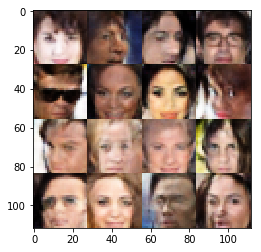

Epoch 2/2... Discriminator Loss: 1.6386... Generator Loss: 0.3590
Epoch 2/2... Discriminator Loss: 1.6550... Generator Loss: 0.3363
Epoch 2/2... Discriminator Loss: 1.6694... Generator Loss: 0.7620
Epoch 2/2... Discriminator Loss: 1.3068... Generator Loss: 0.5415
Epoch 2/2... Discriminator Loss: 1.4720... Generator Loss: 0.7052
Epoch 2/2... Discriminator Loss: 1.5727... Generator Loss: 0.5209
Epoch 2/2... Discriminator Loss: 1.5020... Generator Loss: 0.4798
Epoch 2/2... Discriminator Loss: 1.6336... Generator Loss: 0.3335
Epoch 2/2... Discriminator Loss: 1.5574... Generator Loss: 0.3333
Epoch 2/2... Discriminator Loss: 1.5623... Generator Loss: 0.4404


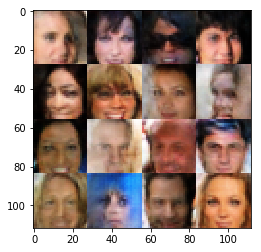

Epoch 2/2... Discriminator Loss: 1.5355... Generator Loss: 0.4996
Epoch 2/2... Discriminator Loss: 1.4757... Generator Loss: 0.5309
Epoch 2/2... Discriminator Loss: 1.7929... Generator Loss: 0.2439


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.